In [327]:
import pandas as pd
data = pd.read_parquet("/mnt/feature_generate_all_np_ag_v5_intern_parquet/ag2508_20250618_features.parquet")
data

KeyboardInterrupt: 

参与训练的特征数量: 4191
>>> 开始训练 LightGBM...
Training until validation scores don't improve for 50 rounds
[10]	valid_0's rmse: 6.94594
[20]	valid_0's rmse: 6.94201
[30]	valid_0's rmse: 6.94115
[40]	valid_0's rmse: 6.93941
[50]	valid_0's rmse: 6.93805
[60]	valid_0's rmse: 6.94039
[70]	valid_0's rmse: 6.94855
[80]	valid_0's rmse: 6.94635
[90]	valid_0's rmse: 6.9471
[100]	valid_0's rmse: 6.94659
Early stopping, best iteration is:
[53]	valid_0's rmse: 6.9374

>>> 计算特征重要性...

>>> 评估验证集 IC...


/tmp/ipykernel_147048/1046098316.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid_df['pred'] = valid_preds


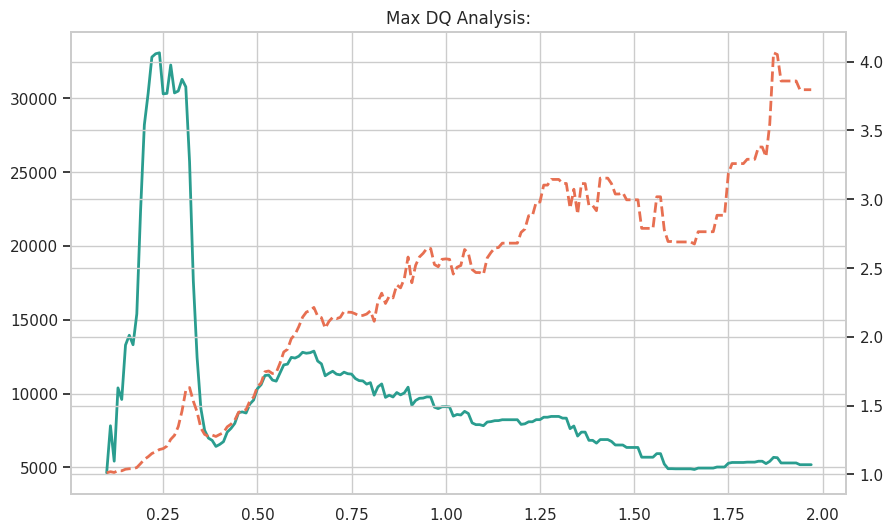

Validation IC: 0.0565
特征重要性已保存至 feature_importance.csv
筛选结果: 从 4191 -> 保留 100 个因子
筛选结果: 从 4191 -> 保留 535 个因子


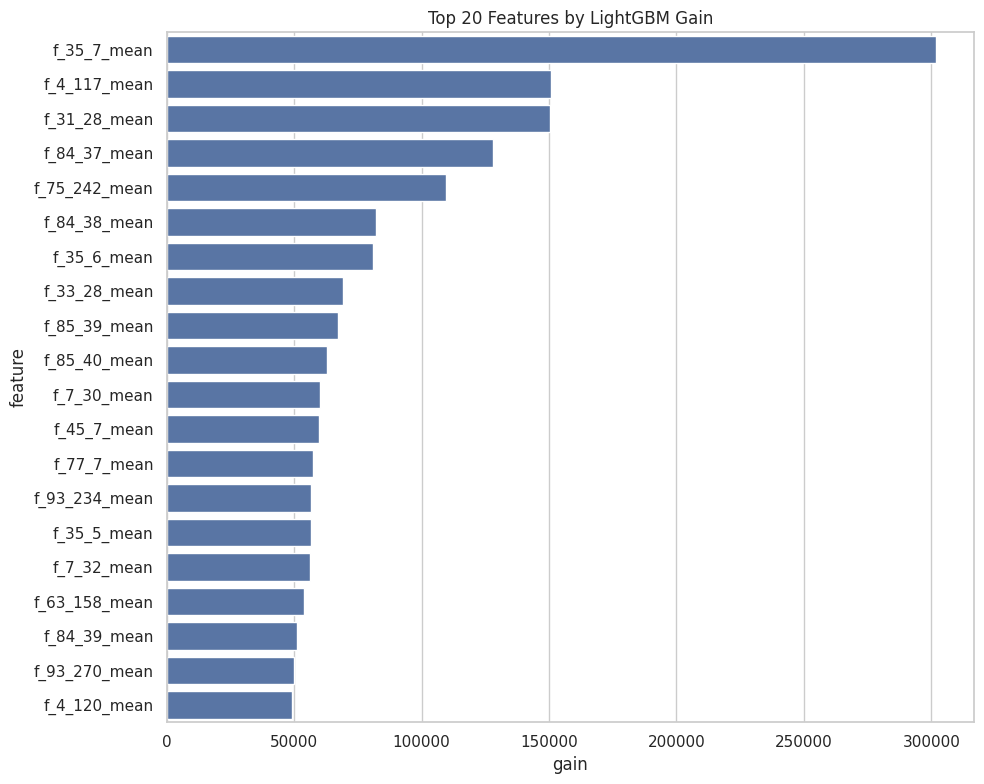

In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 63,
    'max_depth': 5,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.8, 
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'n_jobs': 4,
    'verbose': -1,
    'seed': 42
}

def train_lgbm_and_select_features(train_df, valid_df, label_col='prj2_1_label'):
    """
    训练 LightGBM 并返回特征重要性列表
    """
    # 1. 准备特征列表 (排除 Label 和 Timestamp)
    exclude_cols = ['timestamp', label_col,'trade_day']
    feature_cols = [c for c in train_df.columns if c not in exclude_cols if 'mean' in c]
    
    print(f"参与训练的特征数量: {len(feature_cols)}")
    
    # 2. 构建 LightGBM Dataset
    # 使用 reference 可以节省内存并对齐 bin
    train_data = lgb.Dataset(
        train_df[feature_cols], 
        label=train_df[label_col], 
        feature_name=feature_cols
    )
    
    valid_data = lgb.Dataset(
        valid_df[feature_cols], 
        label=valid_df[label_col], 
        feature_name=feature_cols,
        reference=train_data 
    )
    
    # 3. 训练模型
    print(">>> 开始训练 LightGBM...")
    model = lgb.train(
        LGB_PARAMS,
        train_data,
        num_boost_round=2000,           # 最大轮数
        valid_sets=[valid_data],        # 验证集
        callbacks=[
            lgb.early_stopping(stopping_rounds=50), # 100轮不提升则停止
            lgb.log_evaluation(period=10)            # 每50轮打印一次
        ]
    )
    
    # 4. 提取特征重要性
    print("\n>>> 计算特征重要性...")
    importance_gain = model.feature_importance(importance_type='gain') # 增益 (推荐)
    importance_split = model.feature_importance(importance_type='split') # 分裂次数
    
    feature_imp = pd.DataFrame({
        'feature': feature_cols,
        'gain': importance_gain,
        'split': importance_split
    })
    
    # 按 Gain 降序排列
    feature_imp = feature_imp.sort_values('gain', ascending=False).reset_index(drop=True)
    
    # 计算归一化重要性 (占比)
    feature_imp['gain_normalized'] = feature_imp['gain'] / feature_imp['gain'].sum()
    
    # 5. 在验证集上评估 IC (Information Coefficient)
    print("\n>>> 评估验证集 IC...")
    valid_preds = model.predict(valid_df[feature_cols], num_iteration=model.best_iteration)
    valid_df['pred'] = valid_preds
    thresholds = np.arange(0.0, 10.0, 0.01)
    max_dq = -np.inf
    results = []
    for threshold in thresholds:
            buy_mask = valid_df['pred'] > threshold
            sell_mask = valid_df['pred'] <  -1*threshold
            pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label']
            pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label']
            DQ_buy = np.sum(pnl_buy_raw)
            DQ_sell = np.sum(pnl_sell_raw)     
            DQ = DQ_buy + DQ_sell
            count = len(pnl_buy_raw) + len(pnl_sell_raw)
            if count == 0:
                continue     
            final_DQ = 15 * DQ 
            if final_DQ > max_dq:
                max_dq = final_DQ
            abs_move = np.abs(pnl_buy_raw).sum() + np.abs(pnl_sell_raw).sum()
            dq_neg = (abs_move - DQ) / 2.0
            dq_pos = DQ + dq_neg
            dqr = dq_pos / dq_neg if dq_neg != 0 else 0
            results.append({
                'Threshold': threshold, 
                'DQ': final_DQ, 
                'DQR': dqr, 
                'Count': len(pnl_buy_raw) + len(pnl_sell_raw)
            })
    df_res = pd.DataFrame(results)
    df_res = df_res[(df_res['Count']>50)&(df_res['DQ']>0)]
    if not df_res.empty:
            sns.set_theme(style="whitegrid")
            fig, ax1 = plt.subplots(figsize=(10, 6))
            ax1.plot(df_res['Threshold'], df_res['DQ'], color='#2a9d8f', linewidth=2, label='DQ')
            ax2 = ax1.twinx()
            ax2.plot(df_res['Threshold'], df_res['DQR'], color='#e76f51', linestyle='--', linewidth=2, label='DQR')
            plt.title(f"Max DQ Analysis:")
            plt.show()
    valid_ic, _ = pearsonr(valid_preds, valid_df[label_col].values)
    print(f"Validation IC: {valid_ic:.4f}")
    
    return model, feature_imp

def filter_factors(feature_imp, top_n=None, threshold=0.0):
    """
    根据重要性表筛选因子
    :param top_n: 保留前 N 个
    :param threshold: 保留 gain > threshold 的因子
    """
    if top_n:
        selected = feature_imp.head(top_n)
    elif threshold > 0:
        selected = feature_imp[feature_imp['gain'] > threshold]
    else:
        selected = feature_imp[feature_imp['gain'] > 0] # 默认去除 0 重要性的
        
    print(f"筛选结果: 从 {len(feature_imp)} -> 保留 {len(selected)} 个因子")
    return selected['feature'].tolist()

def plot_importance(feature_imp, top_n=20):
    """画图"""
    plt.figure(figsize=(10, 8))
    sns.barplot(x="gain", y="feature", data=feature_imp.head(top_n))
    plt.title(f'Top {top_n} Features by LightGBM Gain')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    train_df = pd.read_pickle("/home/zyyuan/project2/traindata_augmented_120.pkl")
    valid_df = pd.read_pickle("/home/zyyuan/project2/validdata_augmented_120.pkl")
    if True:
        bst, imp_df = train_lgbm_and_select_features(train_df, valid_df)
        imp_df.to_csv("feature_importance.csv", index=False)
        print("特征重要性已保存至 feature_importance.csv")
        top_factors = filter_factors(imp_df, top_n=100)
        valid_factors = filter_factors(imp_df, threshold=0.0001)
        plot_importance(imp_df, top_n=20)
        
    else:
        print("请先确保 train_df 和 valid_df 在内存中。")

In [ ]:
train_df.shape

(34078, 4614)

In [ ]:
train_df = pd.read_pickle("/home/zyyuan/project2/traindata_augmented_120.pkl")
train_df.shape

(68157, 4614)

In [ ]:
origin_traindf = pd.read_pickle("/home/zyyuan/project2/processed_data/traindata_origin.pkl")
origin_traindf.shape

(68157, 4614)

In [ ]:
train_origin = pd.read_pickle("/home/zyyuan/project2/processed_data/traindata_origin.pkl")
valid_origin = pd.read_pickle("/home/zyyuan/project2/processed_data/validdata_origin.pkl")
train_origin.head()

f_10_1    f_10_2    f_10_3    f_10_4    f_10_5    f_10_6    f_10_7  \
0 -0.107709 -0.408850 -0.322483 -0.262236 -0.200948 -0.096643 -0.072966   
1 -0.017330 -0.003764  0.195202  0.188315  0.099889 -0.025794 -0.024859   
2 -0.025104  0.080840  0.029185  0.134440  0.182094  0.133776  0.006905   
3  0.370944  0.284765  0.228291  0.172322  0.104122  0.135514  0.050706   
4  0.077341  0.187509  0.386767  0.415626  0.438471  0.288988  0.221182   

     f_11_1    f_11_2    f_11_3  ...     f_9_1     f_9_2     f_9_3     f_9_4  \
0  0.037828 -0.093982 -0.053885  ... -0.003074 -0.032824 -0.020870  0.023449   
1 -0.077168 -0.081792 -0.113073  ...  0.019191  0.003647  0.018870  0.001567   
2 -0.093550 -0.114484 -0.041715  ...  0.034262  0.013245  0.020382  0.068362   
3  0.098156  0.170079  0.148553  ...  0.069367  0.073406  0.048879  0.002002   
4  0.101690  0.086186  0.163635  ...  0.123630  0.140689  0.205199  0.215036   

      f_9_5     f_9_6     f_9_7  prj2_1_label               timestamp  \
0  0.018873 -0.067117 -0.067117      1.679719 2025-04-24 21:01:49.500   
1  0.013228  0.015086 -0.045224     -4.815837 2025-04-24 21:02:49.500   
2  0.050593  0.039963 -0.018213     -7.291124 2025-04-24 21:03:49.500   
3  0.011963  0.039112  0.027079    -19.221205 2025-04-24 21:04:49.500   
4  0.172459  0.117526  0.084546    -20.504666 2025-04-24 21:05:49.500   

   trade_day  
0   20250425  
1   20250425  
2   20250425  
3   20250425  
4   20250425  

[5 rows x 4194 columns]

In [ ]:
import pandas as pd
import numpy as np
import os
import joblib  # 用于保存 scaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# ================= 配置区域 =================
CONFIG = {
    # 输入文件路径 (假设是 pickle 格式，如果是 parquet 请自行修改 read_parquet)
    'train_path': '/home/zyyuan/project2/processed_data/traindata_origin.pkl',
    'valid_path': '/home/zyyuan/project2/processed_data/validdata_origin.pkl',
    
    'output_dir': './processed_data_smoothed',
    
    'k': 2,
    
    # 不需要处理的列 (元数据、标签等)
    'exclude_cols': [
        'trade_day', 'timestamp', 'ExchActionDay', 'ExchUpdateTime', 
        'label', 'prj2_1_label', 'prj2_2_label', 'instrument'
    ]
}

def get_feature_columns(df, exclude_cols):
    """自动识别数值型特征列"""
    cols = [c for c in df.columns if c not in exclude_cols]
    numeric_cols = df[cols].select_dtypes(include=[np.number]).columns.tolist()
    return sorted(numeric_cols)

def smooth_dataframe(df, feature_cols, k):
    """
    按交易日分组，对特征列进行滚动均值平滑
    """
    print(f"正在进行滚动平滑 (window={k})...")
    
    # 必须先按时间排序，否则 rolling 没有意义
    if 'timestamp' in df.columns:
        df = df.sort_values(['trade_day', 'timestamp'])
    
    # 复制一份，避免修改原数据
    df_smoothed = df.copy()
    grouped = df.groupby('trade_day')
    
    smoothed_list = []
    indices_list = []
    
    for _, group in tqdm(grouped, desc="Smoothing Days"):
        smoothed_group = group[feature_cols].rolling(window=k,min_periods = 1).mean()
        smoothed_list.append(smoothed_group)
        indices_list.append(group.index)
    full_smoothed = pd.concat(smoothed_list)
    
    # 更新 DataFrame 中的特征列
    # 注意：concat 后的索引可能乱序，需要用 loc 对应索引赋值，或者直接赋值(如果顺序一致)
    df_smoothed.loc[full_smoothed.index, feature_cols] = full_smoothed
    
    # 去除 NaN (每天前 k-1 个数据)
    original_len = len(df_smoothed)
    df_smoothed.dropna(subset=feature_cols, inplace=True)
    print(f"清洗 NaN 数据: {original_len} -> {len(df_smoothed)} 行")
    
    return df_smoothed

def main():
    # 0. 准备环境
    if not os.path.exists(CONFIG['output_dir']):
        os.makedirs(CONFIG['output_dir'])
        
    # 1. 加载数据
    print(">>> Loading Data...")
    train_df = pd.read_pickle(CONFIG['train_path'])
    valid_df = pd.read_pickle(CONFIG['valid_path'])
    
    # 识别特征列
    feature_cols = get_feature_columns(train_df, CONFIG['exclude_cols'])
    print(f"识别到 {len(feature_cols)} 个特征列")
    
    # 2. 平滑 (Smoothing)
    print("\n>>> Processing Train Data (Smoothing)...")
    train_df = smooth_dataframe(train_df, feature_cols, k=CONFIG['k'])
    
    print("\n>>> Processing Valid Data (Smoothing)...")
    valid_df = smooth_dataframe(valid_df, feature_cols, k=CONFIG['k'])
    
    # 3. 标准化 (Standardization)
    print("\n>>> Standardizing...")
    scaler = StandardScaler()
    
    # 3.1 处理 Inf (防止除零导致的无穷大破坏 scaler)
    print("清理 Inf 值...")
    train_df[feature_cols] = train_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(method='ffill')
    valid_df[feature_cols] = valid_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(method='ffill')
    
    # 3.2 Fit on Train
    print("Fitting Scaler on Train...")
    scaler.fit(train_df[feature_cols].values)
    
    # 保存 scaler 方便后续使用
    scaler_path = os.path.join(CONFIG['output_dir'], 'smooth_scaler.pkl')
    joblib.dump(scaler, scaler_path)
    print(f"Scaler saved to {scaler_path}")
    
    # 3.3 Transform Train & Valid
    print("Transforming Train...")
    train_df[feature_cols] = scaler.transform(train_df[feature_cols].values).astype(np.float32)
    
    print("Transforming Valid...")
    valid_df[feature_cols] = scaler.transform(valid_df[feature_cols].values).astype(np.float32)
    
    # 4. 保存结果
    print("\n>>> Saving Results...")
    train_save_path = os.path.join(CONFIG['output_dir'], f"train_smooth_k{CONFIG['k']}.pkl")
    valid_save_path = os.path.join(CONFIG['output_dir'], f"valid_smooth_k{CONFIG['k']}.pkl")
    
    train_df.to_pickle(train_save_path)
    valid_df.to_pickle(valid_save_path)
    
    print("Done!")
    print(f"Train Shape: {train_df.shape}")
    print(f"Valid Shape: {valid_df.shape}")

if __name__ == "__main__":
    main()


>>> Loading Data...
识别到 4191 个特征列

>>> Processing Train Data (Smoothing)...
正在进行滚动平滑 (window=6)...


Smoothing Days: 100%|██████████| 70/70 [00:15<00:00,  4.39it/s]


清洗 NaN 数据: 34093 -> 34093 行

>>> Processing Valid Data (Smoothing)...
正在进行滚动平滑 (window=6)...


Smoothing Days: 100%|██████████| 16/16 [00:02<00:00,  7.79it/s]


清洗 NaN 数据: 7537 -> 7537 行

>>> Standardizing...
清理 Inf 值...


/tmp/ipykernel_3693103/1660737785.py:92: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df[feature_cols] = train_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(method='ffill')
/tmp/ipykernel_3693103/1660737785.py:93: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  valid_df[feature_cols] = valid_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(method='ffill')


Fitting Scaler on Train...
Scaler saved to ./processed_data_smoothed/smooth_scaler.pkl
Transforming Train...
Transforming Valid...

>>> Saving Results...
Done!
Train Shape: (34093, 4194)
Valid Shape: (7537, 4194)


In [ ]:
imp_df.to_csv("feature_importance.csv", index=False)

In [ ]:
imp_df

feature          gain  split  gain_normalized
0      f_31_28  68182.918945      7         0.019725
1      f_85_40  59486.249756      9         0.017209
2       f_35_6  46844.588867      5         0.013552
3      f_85_41  46418.469727      8         0.013429
4      f_84_38  42262.220825      5         0.012226
...        ...           ...    ...              ...
4186    f_63_2      0.000000      0         0.000000
4187   f_63_20      0.000000      0         0.000000
4188   f_63_21      0.000000      0         0.000000
4189   f_63_22      0.000000      0         0.000000
4190  f_63_157      0.000000      0         0.000000

[4191 rows x 4 columns]

In [ ]:
import pandas as pd
train_df = pd.read_pickle("/home/zyyuan/project2/traindata.pkl")
valid_df = pd.read_pickle("/home/zyyuan/project2/validdata.pkl")

In [ ]:
train_df.columns[-704:]

Index(['f_31_28_mean_30', 'f_31_28_amp_30', 'f_31_28_rank_30',
       'f_31_28_slope_30', 'f_85_40_mean_30', 'f_85_40_amp_30',
       'f_85_40_rank_30', 'f_85_40_slope_30', 'f_35_6_mean_30',
       'f_35_6_amp_30',
       ...
       'f_1_34_rank_30', 'f_1_34_slope_30', 'f_35_3_mean_30', 'f_35_3_amp_30',
       'f_35_3_rank_30', 'f_35_3_slope_30', 'f_67_25_mean_30',
       'f_67_25_amp_30', 'f_67_25_rank_30', 'f_67_25_slope_30'],
      dtype='object', length=704)

In [ ]:
if True:
    valid_preds = model.predict(valid_df[feature_cols], num_iteration=model.best_iteration)
    valid_df['pred'] = valid_preds
    thresholds = np.arange(0.0, 10.0, 0.01)
    max_dq = -np.inf
    results = []
    for threshold in thresholds:
            buy_mask = valid_df['pred'] > threshold
            sell_mask = valid_df['pred'] <  -1*threshold
            pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label'] - 0.45
            pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label'] - 0.45
            DQ_buy = np.sum(pnl_buy_raw)
            DQ_sell = np.sum(pnl_sell_raw)     
            DQ = DQ_buy + DQ_sell
            count = len(pnl_buy_raw) + len(pnl_sell_raw)
            if count == 0:
                continue     
            final_DQ = 15 * DQ 
            if final_DQ > max_dq:
                max_dq = final_DQ
            abs_move = np.abs(pnl_buy_raw).sum() + np.abs(pnl_sell_raw).sum()
            dq_neg = (abs_move - DQ) / 2.0
            dq_pos = DQ + dq_neg
            dqr = dq_pos / dq_neg if dq_neg != 0 else 0
            results.append({
                'Threshold': threshold, 
                'DQ': final_DQ, 
                'DQR': dqr, 
                'Count': len(pnl_buy_raw) + len(pnl_sell_raw)
            })
    df_res = pd.DataFrame(results)
    df_res = df_res[(df_res['count']>5)&(df_res['final_DQ']>0)]
    if not df_res.empty:
            sns.set_theme(style="whitegrid")
            fig, ax1 = plt.subplots(figsize=(10, 6))
            ax1.plot(df_res['Threshold'], df_res['DQ'], color='#2a9d8f', linewidth=2, label='DQ')
            ax2 = ax1.twinx()
            ax2.plot(df_res['Threshold'], df_res['DQR'], color='#e76f51', linestyle='--', linewidth=2, label='DQR')
            plt.title(f"Max DQ Analysis:")
            plt.show()

In [ ]:
import pandas as pd
imp_df = pd.read_csv("/home/zyyuan/project2/feature_importance.csv")
import pandas as pd

def select_top_factors_by_group(feature_imp_df, feature_col='feature', score_col='gain', top_k=3):
    """
    根据 f_m_n 的命名规则进行组内筛选
    :param feature_imp_df: 包含因子名和重要性的 DataFrame
    :param feature_col: 因子名称列名
    :param score_col: 重要性得分列名
    :param top_k: 每组保留几个
    :return: 筛选后的因子名称列表
    """
    # 1. 提取组号 (m)
    # 假设格式严格为 f_m_n (例如 f_12_5), split('_')[1] 即为 m
    # 使用 .copy() 避免 SettingWithCopyWarning
    df = feature_imp_df.copy()
    
    try:
        df['group_id'] = df[feature_col].apply(lambda x: str(x).split('_')[1])
    except IndexError:
        print("警告：存在不符合 f_m_n 格式的特征名，请检查数据。")
        # 兜底：如果无法解析，可能保留原名作为组，或者跳过
        return []

    # 2. 预筛选：剔除重要性 <= 0 的特征
    # 这一步非常关键：
    # A. 它保证了选出来的特征一定是有用的。
    # B. 它自动实现了“如果该组importance全部为0，则去掉”的逻辑（因为组内都被删光了）。
    df_active = df[df[score_col] > 0]
    
    if df_active.empty:
        print("所有特征重要性均为 0，未选中任何因子。")
        return []

    # 3. 组内排序并取 Top K
    # 先按重要性全局降序 (这样 groupby().head() 就会取到最大的)
    df_sorted = df_active.sort_values(by=score_col, ascending=False)
    
    # 按 group_id 分组，并取每组的前 top_k 个
    selected_df = df_sorted.groupby('group_id').head(top_k)
    
    # 4. 统计结果
    print(f"原始特征数: {len(feature_imp_df)}")
    print(f"有效(>0)特征数: {len(df_active)}")
    print(f"筛选后特征数: {len(selected_df)} (覆盖 {selected_df['group_id'].nunique()} 个分组)")
    
    return selected_df[feature_col].tolist()

# ================= 使用示例 =================

if __name__ == "__main__":
    final_list = select_top_factors_by_group(
        imp_df, 
        feature_col='feature', 
        score_col='gain', # 请替换为你实际的列名，如 'importance' 或 'gain'
        top_k=3
    )
    
    print("\n最终筛选结果列表:")
    print(final_list)

原始特征数: 4191
有效(>0)特征数: 690
筛选后特征数: 210 (覆盖 82 个分组)

最终筛选结果列表:
['f_35_7', 'f_4_117', 'f_84_37', 'f_31_28', 'f_84_38', 'f_7_32', 'f_7_30', 'f_92_383', 'f_74_362', 'f_33_28', 'f_35_5', 'f_75_239', 'f_8_29', 'f_4_120', 'f_92_322', 'f_35_6', 'f_87_45', 'f_93_234', 'f_5_27', 'f_92_326', 'f_85_40', 'f_63_158', 'f_6_104', 'f_31_24', 'f_93_241', 'f_36_7', 'f_93_224', 'f_85_37', 'f_7_29', 'f_6_112', 'f_75_203', 'f_5_28', 'f_6_85', 'f_77_7', 'f_75_238', 'f_5_26', 'f_85_39', 'f_79_35', 'f_17_35', 'f_44_7', 'f_86_46', 'f_63_6', 'f_64_159', 'f_87_43', 'f_34_7', 'f_17_41', 'f_84_33', 'f_79_31', 'f_32_28', 'f_71_77', 'f_79_32', 'f_19_31', 'f_4_119', 'f_18_30', 'f_52_34', 'f_43_7', 'f_90_44', 'f_55_42', 'f_47_6', 'f_17_24', 'f_73_83', 'f_53_12', 'f_34_5', 'f_20_47', 'f_43_6', 'f_91_44', 'f_64_158', 'f_8_25', 'f_74_361', 'f_18_37', 'f_43_5', 'f_16_46', 'f_20_38', 'f_64_98', 'f_89_24', 'f_52_8', 'f_32_5', 'f_53_28', 'f_55_40', 'f_53_34', 'f_86_47', 'f_80_18', 'f_73_78', 'f_73_77', 'f_61_21', 'f_32_8', 'f

In [ ]:
df_res

Threshold            DQ        DQR  Count
28        0.28   1280.345828   1.003521  10726
29        0.29    452.111889   1.001263  10556
30        0.30   3643.093451   1.010404  10379
31        0.31   5409.631385   1.015690  10235
32        0.32   4556.674418   1.013389  10076
..         ...           ...        ...    ...
599       5.99  16527.629708  61.150870     52
600       6.00  16527.629708  61.150870     52
601       6.01  16527.629708  61.150870     52
602       6.02  16527.629708  61.150870     52
603       6.03  15918.711378  58.934765     51

[576 rows x 4 columns]

In [ ]:
thresholds = np.arange(0.0, 10.0, 0.01)
max_dq = -np.inf
df_res = pd.DataFrame(columns = )
for threshold in thresholds:
        buy_mask = valid_df['pred'] > threshold
        sell_mask = valid_df['pred'] <  -1*threshold
        pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label'] - 0.45
        pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label'] - 0.45
        DQ_buy = np.sum(pnl_buy_raw)
        DQ_sell = np.sum(pnl_sell_raw)     
        DQ = DQ_buy + DQ_sell
        count = len(pnl_buy_raw) + len(pnl_sell_raw)
        if count == 0:
            continue     
        final_DQ = 15 * DQ 
        if final_DQ > max_dq:
            max_dq = final_DQ
print(max_dq)

8941.394193567463


In [ ]:
factordata = pd.read_pickle("/home/zyyuan/project2/factor_all.pkl")
factordata

ExchActionDay ExchUpdateTime  ExchUpdateMillisec  prj2_1_label  \
59          20250424        21:1:19                 500      2.895925   
119         20250424        21:1:49                 500      1.679719   
179         20250424        21:2:19                 500     -2.679545   
239         20250424        21:2:49                 500     -4.815837   
299         20250424        21:3:19                 500     -5.407008   
...              ...            ...                 ...           ...   
59219       20250829       14:56:36                 500           NaN   
59279       20250829        14:57:9                   0           NaN   
59339       20250829       14:57:41                   0           NaN   
59399       20250829       14:58:13                   0           NaN   
59459       20250829       14:58:43                 500           NaN   

                    timestamp type source   trade_day  action_day    inst  \
59    2025-04-24 21:01:19.500    D      M  2025-04-25  2025-04-24  ag2506   
119   2025-04-24 21:01:49.500    D      M  2025-04-25  2025-04-24  ag2506   
179   2025-04-24 21:02:19.500    D      M  2025-04-25  2025-04-24  ag2506   
239   2025-04-24 21:02:49.500    D      M  2025-04-25  2025-04-24  ag2506   
299   2025-04-24 21:03:19.500    D      M  2025-04-25  2025-04-24  ag2506   
...                       ...  ...    ...         ...         ...     ...   
59219 2025-08-29 14:56:36.500    D      M  2025-08-29  2025-08-29  ag2510   
59279 2025-08-29 14:57:09.000    D      M  2025-08-29  2025-08-29  ag2510   
59339 2025-08-29 14:57:41.000    D      M  2025-08-29  2025-08-29  ag2510   
59399 2025-08-29 14:58:13.000    D      M  2025-08-29  2025-08-29  ag2510   
59459 2025-08-29 14:58:43.500    D      M  2025-08-29  2025-08-29  ag2510   

       ... struct_rev_30  volume_threshold  trend_10  trend_30       atr  \
59     ...           NaN               NaN       NaN       NaN       NaN   
119    ...           NaN               NaN       NaN       NaN       NaN   
179    ...           NaN               NaN       NaN       NaN       NaN   
239    ...           NaN               NaN       NaN       NaN       NaN   
299    ...           NaN               NaN       NaN       NaN       NaN   
...    ...           ...               ...       ...       ...       ...   
59219  ...     -3.297982        667.000000 -0.000027 -0.000019  0.000247   
59279  ...     -1.727615        667.000000 -0.000040 -0.000031  0.000251   
59339  ...     -2.196186        667.000000 -0.000062 -0.000046  0.000251   
59399  ...     -1.764583        667.000000 -0.000087 -0.000057  0.000236   
59459  ...     -0.346792        671.599976 -0.000037 -0.000019  0.000213   

              ma20  upper_bb  lower_bb  turnover_5min  turnover_10min  
59             NaN       NaN       NaN            NaN             NaN  
119            NaN       NaN       NaN            NaN             NaN  
179            NaN       NaN       NaN            NaN             NaN  
239            NaN       NaN       NaN            NaN             NaN  
299            NaN       NaN       NaN      5427477.0             NaN  
...            ...       ...       ...            ...             ...  
59219  9386.150391  0.000330 -0.000192       112623.0        197088.0  
59279  9386.200195  0.000228 -0.000292       168945.0        183016.5  
59339  9386.250000  0.000133 -0.000400       140787.0        154864.5  
59399  9386.275391  0.000192 -0.000346        84477.0        140788.5  
59459  9386.275391  0.000138 -0.000399        84483.0        140790.0  

[88869 rows x 327 columns]

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_decile_means(df, factor_cols, label_col):
    """
    计算因子十分位分组的 Label 均值
    
    Args:
        df: 包含因子和 Label 的 DataFrame
        factor_cols: 因子列名列表
        label_col: Label 列名
        
    Returns:
        pd.DataFrame: Index为因子名，Columns为 Decile_1 到 Decile_10
    """
    stats_dict = {}
    
    # 使用 tqdm 显示进度
    for factor in tqdm(factor_cols, desc="Grouping Factors"):
        try:
            # 1. 剔除因子或Label为空的行 (可选，视数据质量而定)
            curr_df = df[[factor, label_col]].dropna()
            
            if len(curr_df) < 10: # 数据太少跳过
                continue
                
            # 2. qcut 分组
            # labels=False: 返回 0-9 的整数索引
            # duplicates='drop': 如果因子有大量重复值导致无法分成10组，会自动合并组
            bins = pd.qcut(curr_df[factor], 10, labels=False, duplicates='drop')
            
            # 3. 计算各组 Label 均值
            group_means = curr_df.groupby(bins)[label_col].mean()
            
            # 4. 强制重新索引到 0-9
            # 这一步是为了处理 duplicates='drop' 导致少于 10 组的情况，以及对齐格式
            # 缺失的组会填充 NaN
            group_means = group_means.reindex(range(10))
            
            stats_dict[factor] = group_means
            
        except Exception as e:
            print(f"Error processing {factor}: {e}")
            
    # 5. 转换为 DataFrame (转置，使得 Index 是因子)
    result_df = pd.DataFrame(stats_dict).T
    
    # 6. 重命名列名 (1-10)
    result_df.columns = [f'D{i+1}' for i in range(10)]
    
    # 7. 计算多空收益差 (Spread: D10 - D1) 和 单调性分数 (可选)
    # 这里的 D10 是最大值组，D1 是最小值组
    result_df['Spread'] = result_df['D10'] - result_df['D1']
    
    return result_df
res = calculate_decile_means(factordata,factordata.columns[86:],'prj2_1_label')
res['score'] = res['Spread'].abs()
res

Grouping Factors:  22%|██▏       | 52/241 [00:00<00:01, 102.06it/s]/home/zyyuan/zyy/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/zyyuan/zyy/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
Grouping Factors:  51%|█████     | 123/241 [00:01<00:01, 110.42it/s]/home/zyyuan/zyy/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
Grouping Factors:  66%|██████▌   | 158/241 [00:01<00:00, 110.55it/s]/home/zyyuan/zyy/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/zyyuan/zyy/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4673: RuntimeWarning: invalid value encountered in

D1        D2        D3        D4        D5        D6  \
order_imbalance  0.310923  0.261560  0.270885  0.185656  0.110452 -0.055158   
OI_MA_10         0.334621  0.370328  0.205695  0.119215  0.161138  0.043499   
OI_MA_60         0.427436  0.266342  0.323188  0.243641  0.212556 -0.129422   
OI_MA_120        0.482029  0.360226  0.320655  0.308843  0.102141 -0.092872   
OI_MA_300        0.597060  0.280867  0.442724  0.404926  0.041256 -0.102657   
...                   ...       ...       ...       ...       ...       ...   
ma20             0.310089  0.186946  0.073675  0.317462  0.074198 -0.025675   
upper_bb         0.279118  0.369822  0.397808  0.347483  0.378774  0.337899   
lower_bb        -0.010540 -0.002470  0.112769  0.125611  0.191574  0.142539   
turnover_5min    0.159147  0.367947  0.169073  0.352758  0.106548  0.090894   
turnover_10min   0.120915  0.266759  0.333454  0.433586  0.171040 -0.063744   

                       D7        D8        D9       D10    Spread     score  
order_imbalance  0.008034 -0.071676 -0.131592 -0.000947 -0.311870  0.311870  
OI_MA_10        -0.150832 -0.020681 -0.142966 -0.031876 -0.366497  0.366497  
OI_MA_60        -0.102362 -0.150338 -0.046041 -0.156839 -0.584276  0.584276  
OI_MA_120       -0.180583 -0.233320 -0.030667 -0.152551 -0.634579  0.634579  
OI_MA_300       -0.173723 -0.429482 -0.155334 -0.064576 -0.661636  0.661636  
...                   ...       ...       ...       ...       ...       ...  
ma20             0.433320  0.231206 -0.476118 -0.199179 -0.509268  0.509268  
upper_bb         0.054457 -0.269782 -0.328876 -0.640570 -0.919688  0.919688  
lower_bb         0.199599  0.160039  0.072799 -0.065810 -0.055269  0.055269  
turnover_5min    0.038835 -0.129974 -0.031066 -0.283017 -0.442164  0.442164  
turnover_10min  -0.053968  0.167980  0.037012 -0.547061 -0.667976  0.667976  

[234 rows x 12 columns]

In [ ]:
factor_test = pd.read_pickle("/home/zyyuan/project2/factor_all_test.pkl")
res_test = calculate_decile_means(factor_test,factordata.columns[86:],'label')
res_test['score'] = res_test['Spread'].abs()
res_test

Grouping Factors:  33%|███▎      | 79/241 [00:00<00:00, 194.95it/s]/home/zyyuan/zyy/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4673: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
Grouping Factors:  49%|████▉     | 119/241 [00:00<00:00, 194.27it/s]/home/zyyuan/zyy/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
Grouping Factors: 100%|██████████| 241/241 [00:01<00:00, 196.33it/s]


D1        D2        D3        D4        D5        D6  \
order_imbalance  1.135814  0.824382  0.755343  0.845245  0.670790  0.697205   
OI_MA_10         1.177137  0.956602  0.762611  0.752619  0.753990  0.619860   
OI_MA_60         1.107299  1.067679  0.944473  0.874557  0.582917  0.713911   
OI_MA_120        1.045297  1.102273  1.059209  0.869244  0.737424  0.698673   
OI_MA_300        1.020763  1.148735  1.095919  1.019041  0.795450  0.678376   
...                   ...       ...       ...       ...       ...       ...   
ma20             0.613028  0.196958  0.168322  0.411365  0.601661  0.592749   
upper_bb         1.720221  0.846010  0.832408  0.889266  0.826954  0.938366   
lower_bb         2.833288  1.516074  0.814322  0.637455  0.395441  0.409317   
turnover_5min    0.169108  0.281155  0.427450  0.389936  0.513479  0.681341   
turnover_10min   0.211705  0.278889  0.207664  0.437546  0.525631  0.669278   

                       D7        D8        D9       D10    Spread     score  
order_imbalance  0.568400  0.497626  0.421034  0.540472 -0.595342  0.595342  
OI_MA_10         0.672575  0.461766  0.367724  0.431457 -0.745681  0.745681  
OI_MA_60         0.582007  0.478204  0.270842  0.334513 -0.772786  0.772786  
OI_MA_120        0.559154  0.352022  0.266236  0.270277 -0.775020  0.775020  
OI_MA_300        0.568819  0.307677  0.224206  0.082266 -0.938497  0.938497  
...                   ...       ...       ...       ...       ...       ...  
ma20             0.275430 -0.001608  1.114289  2.500967  1.887939  1.887939  
upper_bb         0.922426  0.713236  0.372950 -1.588676 -3.308897  3.308897  
lower_bb         0.188663  0.146622  0.016774 -0.484795 -3.318084  3.318084  
turnover_5min    0.856958  0.882004  1.396831  1.343048  1.173939  1.173939  
turnover_10min   0.706176  0.850947  1.542213  1.399553  1.187848  1.187848  

[234 rows x 12 columns]

In [ ]:
factor_list = ['adtm_30m','coppock_10_15_30m','rsj_30','TrendStrenth_30','ar_30','macd_long','rsi_long','cmo_30','mfi_30m','upper_bb','variance_diff_30m','pv_corr_10','OI_MA_600','netflow_30min','PSY_60','cci_30','amivest_lr_30','effective_depth_10min','skew_overall_10m','regression_factor_10','oi_vol_corr_30','rp_momentum_600','lower_band','net_inflow_min']
len(factor_list)

24

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib  # 用于保存 scaler
import os

def standardize_factors(train_df, valid_df, factors, save_dir='./model_checkpoints'):
    """
    对因子列进行标准化 (Z-Score)
    规则：在 Train 上 fit (计算均值方差)，在 Train 和 Valid 上 transform
    """
    # 0. 准备工作
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    print(f">>> 开始标准化 {len(factors)} 个因子...")
    
    # 1. 初始化 Scaler
    scaler = StandardScaler()
    
    # 2. 提取数据 (建议转换为 float32 节省内存)
    # 注意：这里使用 copy() 防止 SettingWithCopyWarning，虽然直接赋值通常也行
    X_train = train_df[factors].values.astype(np.float32)
    X_valid = valid_df[factors].values.astype(np.float32)
    
    # 3. 核心步骤：Fit on Train
    print("    Fitting scaler on Train set...")
    scaler.fit(X_train)
    
    # 4. 转换数据 (Transform)
    print("    Transforming Train & Valid sets...")
    # fit_transform 等价于先 fit 再 transform，但在训练集上通常合起来写
    train_df[factors] = scaler.transform(X_train) 
    
    # 验证集只能 transform！绝对不能 fit！
    valid_df[factors] = scaler.transform(X_valid)
    train_df[factors] = train_df[factors].replace([np.inf, -np.inf], np.nan)
    train_df[factors] = train_df[factors].fillna(0)
    valid_df[factors] = valid_df[factors].replace([np.inf, -np.inf], np.nan)
    valid_df[factors] = valid_df[factors].fillna(0)
    # 5. 保存 Scaler
    # 这步非常重要，因为实盘预测时，新数据也需要用这个 scaler 进行处理
    scaler_path = os.path.join(save_dir, 'factor_scaler.pkl')
    joblib.dump(scaler, scaler_path)
    print(f"    Scaler 已保存至: {scaler_path}")
    
    # 打印部分统计量检查
    print(f"    检查: Train 均值(应接近0): {train_df[factors[0]].mean():.4f}")
    print(f"    检查: Valid 均值(不一定为0): {valid_df[factors[0]].mean():.4f}")
    
    return train_df, valid_df
train_new = pd.merge(left = train_df,right = factordata[factordata.columns[86:].tolist()+['timestamp']],on = ['timestamp'],how = 'left')
valid_new = pd.merge(left = valid_df,right = factordata[factordata.columns[86:].tolist()+['timestamp']],on = ['timestamp'],how = 'left')
# train_new, valid_new = standardize_factors(train_new, valid_new, factor_list)


In [ ]:
train_new = pd.merge(left = train_df,right = factordata[context_factors[5:]+['cvar_10','bigorder_pct']+['timestamp']],on = ['timestamp'],how = 'left')
valid_new = pd.merge(left = valid_df,right = factordata[context_factors[5:]+['cvar_10','bigorder_pct']+['timestamp']],on = ['timestamp'],how = 'left')

In [ ]:
train_new.to_pickle("traindata_market.pkl")
valid_new.to_pickle("validdata_market.pkl")

开始重训 (Refitting) - 使用特征数: 24
Training until validation scores don't improve for 50 rounds
[20]	valid_0's rmse: 6.95586
[40]	valid_0's rmse: 6.9655
Early stopping, best iteration is:
[1]	valid_0's rmse: 6.94837

>>> 正在评估重训模型性能...


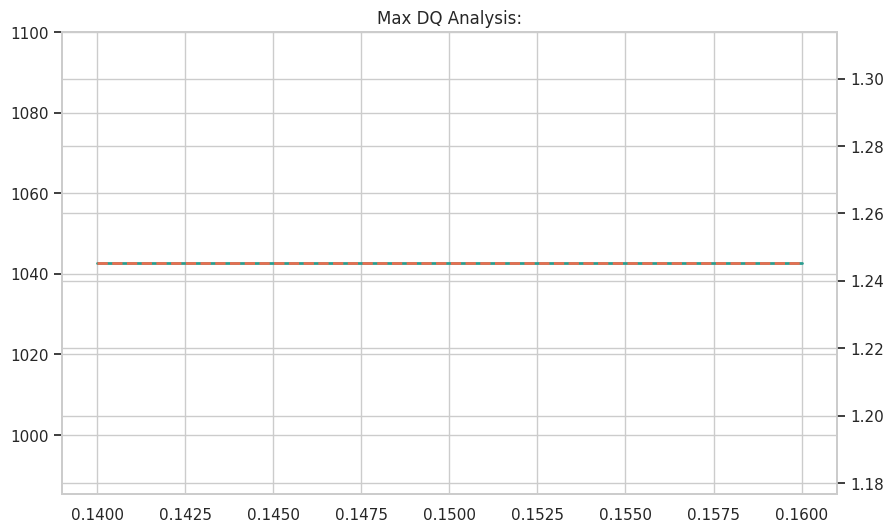

----------------------------------------
Refit Results:
Feature Count : 24
Validation IC : -0.056746  <-- 核心关注指标
Validation RMSE: 6.948368
----------------------------------------


In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 63,
    'max_depth': 6,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.8, 
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'n_jobs': 4,
    'verbose': -1,
    'seed': 42
}
def retrain_with_selected_features(train_df, valid_df, selected_features, params=LGB_PARAMS, label_col='prj2_1_label'):
    """
    仅使用筛选后的 top_factors 进行重训并评估
    """
    print(f"========================================")
    print(f"开始重训 (Refitting) - 使用特征数: {len(selected_features)}")
    print(f"========================================")
    
    # 1. 构建精简版 Dataset
    # 注意：只传入 selected_features
    train_data = lgb.Dataset(
        train_df[selected_features], 
        label=train_df[label_col], 
        feature_name=selected_features
    )
    
    valid_data = lgb.Dataset(
        valid_df[selected_features], 
        label=valid_df[label_col], 
        feature_name=selected_features,
        reference=train_data 
    )
    
    # 2. 训练模型 (参数保持不变)
    # 注意：如果特征数特别少（例如<20个），feature_fraction=0.1 可能太小导致无法分裂
    # 但为了控制变量，这里先保持不变，除非报错或效果极差
    model = lgb.train(
        params,
        train_data,
        num_boost_round=2000,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=20)
        ]
    )
    
    # 3. 评估效果
    print("\n>>> 正在评估重训模型性能...")
    
    # 预测验证集
    valid_preds = model.predict(valid_df[selected_features], num_iteration=model.best_iteration)
    valid_df['pred'] = valid_preds
    thresholds = np.arange(0.0, 10.0, 0.01)
    max_dq = -np.inf
    results = []
    for threshold in thresholds:
            buy_mask = valid_df['pred'] > threshold
            sell_mask = valid_df['pred'] <  -1*threshold
            pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label'] - (0.5/10000)*valid_df.loc[buy_mask,'LABEL_CAL_DQ_inst1_60']
            pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label'] - (0.5/10000)*valid_df.loc[sell_mask,'LABEL_CAL_DQ_inst1_60']
            # print(valid_df.loc[buy_mask,'LABEL_CAL_DQ_inst1_60'].sum(),valid_df.loc[sell_mask,'LABEL_CAL_DQ_inst1_60'].sum())
            # pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label']
            # pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label']
            DQ_buy = np.sum(pnl_buy_raw)
            DQ_sell = np.sum(pnl_sell_raw)
            # print(0.44*len(pnl_buy_raw),0.44*len(pnl_sell_raw),DQ_buy+DQ_sell)
            DQ = DQ_buy + DQ_sell
            count = len(pnl_buy_raw) + len(pnl_sell_raw)
            if count == 0:
                continue     
            final_DQ = 15 * DQ 
            if final_DQ > max_dq:
                max_dq = final_DQ
            abs_move = np.abs(pnl_buy_raw).sum() + np.abs(pnl_sell_raw).sum()
            dq_neg = (abs_move - DQ) / 2.0
            dq_pos = DQ + dq_neg
            dqr = dq_pos / dq_neg if dq_neg != 0 else 0
            results.append({
                'Threshold': threshold, 
                'DQ': final_DQ, 
                'DQR': dqr, 
                'Count': len(pnl_buy_raw) + len(pnl_sell_raw)
            })
    df_res = pd.DataFrame(results)
    df_res = df_res[(df_res['Count']>50)&(df_res['DQ']>0)]
    if not df_res.empty:
            sns.set_theme(style="whitegrid")
            fig, ax1 = plt.subplots(figsize=(10, 6))
            ax1.plot(df_res['Threshold'], df_res['DQ'], color='#2a9d8f', linewidth=2, label='DQ')
            ax2 = ax1.twinx()
            ax2.plot(df_res['Threshold'], df_res['DQR'], color='#e76f51', linestyle='--', linewidth=2, label='DQR')
            plt.title(f"Max DQ Analysis:")
            plt.show()
    # 计算 IC (Information Coefficient - 皮尔逊相关系数)
    # 这是量化中最看重的指标，代表预测值和真实值的排序相关性
    ic, p_value = pearsonr(valid_preds, valid_df[label_col].values)
    
    # 计算 RMSE
    mse = np.mean((valid_preds - valid_df[label_col].values) ** 2)
    rmse = np.sqrt(mse)
    
    print(f"----------------------------------------")
    print(f"Refit Results:")
    print(f"Feature Count : {len(selected_features)}")
    print(f"Validation IC : {ic:.6f}  <-- 核心关注指标")
    print(f"Validation RMSE: {rmse:.6f}")
    print(f"----------------------------------------")
    
    return model, {'ic': ic, 'rmse': rmse},df_res

# ================= 使用示例 =================

if __name__ == "__main__":
    final_model, metrics,df_res = retrain_with_selected_features(
            train_new, 
            valid_new, 
            factor_list, 
            params=LGB_PARAMS
        )
        
    final_model.save_model(f'lgbm_top{top_n}_model.txt')

In [ ]:
train_new[factor_list].describe()

adtm_30m  coppock_10_15_30m        rsj_30  TrendStrenth_30  \
count  6.815700e+04       6.519000e+04  6.615600e+04     6.615600e+04   
mean  -8.955083e-09      -4.681328e-09 -3.690378e-09     9.225944e-10   
std    1.000007e+00       1.000008e+00  1.000008e+00     1.000008e+00   
min   -2.299410e+00      -8.415082e+00 -3.567631e+00    -3.650047e+00   
25%   -8.222196e-01      -4.393409e-01 -6.689595e-01    -6.942192e-01   
50%   -1.024835e-02       3.600992e-02  5.644225e-03     1.112431e-02   
75%    8.291543e-01       4.961757e-01  6.770630e-01     6.871210e-01   
max    2.219570e+00       7.510618e+00  3.473994e+00     4.203259e+00   

              ar_30     macd_long      rsi_long        cmo_30       mfi_30m  \
count  6.753600e+04  6.815700e+04  6.815600e+04  6.815700e+04  6.815700e+04   
mean   1.830079e-08 -1.791017e-09 -1.379103e-07  7.164066e-09  8.955083e-10   
std    1.000007e+00  1.000007e+00  1.000007e+00  1.000007e+00  1.000007e+00   
min   -1.816061e+00 -7.019389e+00 -6.039534e+00 -4.337826e+00 -2.542971e+00   
25%   -7.092322e-01 -4.225385e-01 -5.390044e-01 -6.771546e-01 -6.803160e-01   
50%   -1.945017e-01  4.837076e-02  4.690287e-02  9.148519e-03 -7.867859e-02   
75%    4.883246e-01  4.822027e-01  5.904440e-01  6.735131e-01  5.592799e-01   
max    8.609862e+00  5.773701e+00  5.194233e+00  4.180915e+00  3.232470e+00   

           upper_bb  ...        PSY_60        cci_30  amivest_lr_30  \
count  6.691500e+04  ...  6.415500e+04  6.815700e+04   6.777000e+04   
mean   1.915472e-08  ...  1.331918e-07  3.134279e-09  -2.161493e-08   
std    1.000007e+00  ...  1.000008e+00  1.000007e+00   1.000007e+00   
min   -4.810699e+00  ... -3.507872e+00 -8.167629e+00  -1.414075e+00   
25%   -5.539030e-01  ... -6.210710e-01 -7.288354e-01  -6.803522e-01   
50%   -2.625555e-01  ...  1.006289e-01 -5.264697e-03  -2.424164e-01   
75%    2.207018e-01  ...  5.817624e-01  7.150930e-01   3.905753e-01   
max    1.465002e+01  ...  3.468563e+00  7.235080e+00   1.076251e+01   

       effective_depth_10min  skew_overall_10m  regression_factor_10  \
count           6.815700e+04      6.753600e+04          6.760500e+04   
mean           -4.298440e-08      1.445988e-08         -2.257050e-09   
std             1.000007e+00      1.000007e+00          1.000007e+00   
min            -1.636677e+00     -3.784809e+00         -1.738804e+01   
25%            -7.672969e-01     -6.126000e-01         -3.555621e-01   
50%            -2.407988e-01     -3.843176e-02         -7.101521e-03   
75%             5.211601e-01      6.061779e-01          3.627570e-01   
max             4.667318e+00      3.698184e+00          1.133353e+01   

       oi_vol_corr_30  rp_momentum_600    lower_band  net_inflow_min  
count    6.608700e+04     6.808800e+04  6.684600e+04    6.815700e+04  
mean     4.848678e-09    -4.482079e-10  1.753097e-07    3.134279e-09  
std      1.000008e+00     1.000007e+00  1.000007e+00    1.000007e+00  
min     -2.486352e+00    -4.151718e+01 -1.924298e+00   -6.835999e+01  
25%     -7.546709e-01     2.705495e-03 -1.152926e+00   -1.471314e-01  
50%     -1.077757e-02     8.179344e-03  2.025204e-01   -1.629837e-03  
75%      7.380821e-01     1.388783e-02  7.644145e-01    1.451153e-01  
max      2.740401e+00     3.483530e+01  1.895596e+00    3.546095e+01  

[8 rows x 24 columns]

In [ ]:
train_df.shape,valid_df.shape

((68157, 4679), (15067, 4680))

In [ ]:
res.loc['net_inflow_min']

D1        0.011451
D2        0.078105
D3        0.458902
D4        0.120076
D5        0.196125
D6        0.209535
D7        0.173302
D8       -0.019017
D9       -0.036768
D10      -0.311420
Spread   -0.322871
score     0.322871
Name: net_inflow_min, dtype: float32

In [ ]:
factor_test = pd.DataFrame(columns = ['train','valid'])
res = calculate_decile_means(train_df,top_factors,'prj2_1_label')
res['score'] = res['Spread'].abs()
factor_test['train'] = res['Spread']
factor_test['score'] = factor_test['train'].abs()
res = calculate_decile_means(valid_df,top_factors,'prj2_1_label')
factor_test['valid'] = res['Spread']
factor_list = factor_test[(factor_test['train']*factor_test['valid']>0)&(factor_test['score']>=0.1)].index.tolist()

Grouping Factors: 100%|██████████| 300/300 [00:00<00:00, 365.97it/s]


In [ ]:
uselist = ['f_4_120_amp', 'f_4_119_amp', 'f_1_42_amp','f_74_362_trend']

In [ ]:
amp_list = [x for x in train_df.columns if '_amp' in x]
trend_list = [x for x in train_df.columns if '_trend' in x]
res = calculate_decile_means(train_df,trend_list,'prj2_1_label')
res['avg_spread'] = res['Spread'].abs()
# res.sort_values(by = 'avg_spread',ascending=False)
trend_list = res[res['avg_spread']>0.4].index.tolist()

Grouping Factors: 100%|██████████| 210/210 [00:01<00:00, 146.50it/s]


In [ ]:
dailydata = pd.read_csv("/home/zyyuan/project1/try/market_data/20250425_SHFE_ag2506.csv")
r60 = dailydata.rolling(120)
dailydata['sum_to_60s'] = r60['turnover'].sum()
dailydata['sum_vol_60s'] = r60['volume'].sum()
r900 = dailydata.rolling(1800)
dailydata['sum_to_900s'] = r900['turnover'].sum()
dailydata['sum_vol_900s'] = r900['volume'].sum()
dailydata['vwap_60'] = (dailydata['sum_to_60s'].shift(-120)/dailydata['sum_vol_60s'].shift(-120))/15
dailydata['vwap_60_900'] = ((dailydata['sum_to_900s'].shift(-1800)-dailydata['sum_to_60s'].shift(-120))/(dailydata['sum_vol_900s'].shift(-1800)-dailydata['sum_vol_60s'].shift(-120)))/15
dailydata['label'] = dailydata['vwap_60_900'] - dailydata['vwap_60']
dailydata

type source   trade_day  action_day    inst                  hms   ms  \
0        D      M  2025-04-25  2025-04-24  ag2506  2025-04-24 20:59:00  500   
1        D      M  2025-04-25  2025-04-24  ag2506  2025-04-24 21:00:00  500   
2        D      M  2025-04-25  2025-04-24  ag2506  2025-04-24 21:00:01    0   
3        D      M  2025-04-25  2025-04-24  ag2506  2025-04-24 21:00:01  500   
4        D      M  2025-04-25  2025-04-24  ag2506  2025-04-24 21:00:02    0   
...    ...    ...         ...         ...     ...                  ...  ...   
64974    D      M  2025-04-25  2025-04-25  ag2506  2025-04-25 14:59:58  500   
64975    D      M  2025-04-25  2025-04-25  ag2506  2025-04-25 14:59:59    0   
64976    D      M  2025-04-25  2025-04-25  ag2506  2025-04-25 14:59:59  500   
64977    D      M  2025-04-25  2025-04-25  ag2506  2025-04-25 15:00:00    0   
64978    D      M  2025-04-25  2025-04-25  ag2506  2025-04-25 15:00:00  500   

       last  volume   bp1  ...  ordercnt_ask5  bid_total_price  \
0      8298     409  8297  ...              0                0   
1      8296     566  8296  ...              0                0   
2      8299     735  8298  ...              0                0   
3      8298     920  8296  ...              0                0   
4      8296    1126  8293  ...              0                0   
...     ...     ...   ...  ...            ...              ...   
64974  8279  638036  8278  ...              0                0   
64975  8279  638058  8278  ...              0                0   
64976  8280  638122  8280  ...              0                0   
64977  8280  638127  8280  ...              0                0   
64978  8280  638127  8280  ...              0                0   

       ask_total_price    sum_to_60s  sum_vol_60s   sum_to_900s  sum_vol_900s  \
0                    0           NaN          NaN           NaN           NaN   
1                    0           NaN          NaN           NaN           NaN   
2                    0           NaN          NaN           NaN           NaN   
3                    0           NaN          NaN           NaN           NaN   
4                    0           NaN          NaN           NaN           NaN   
...                ...           ...          ...           ...           ...   
64974                0  9.509099e+12   76424926.0  1.409757e+14  1.133002e+09   
64975                0  9.509368e+12   76427091.0  1.409777e+14  1.133017e+09   
64976                0  9.509640e+12   76429284.0  1.409797e+14  1.133033e+09   
64977                0  9.509908e+12   76431438.0  1.409816e+14  1.133049e+09   
64978                0  9.510171e+12   76433556.0  1.409836e+14  1.133065e+09   

           vwap_60  vwap_60_900     label  
0      8292.770938  8298.332850  5.561912  
1      8292.760575  8298.331644  5.571069  
2      8292.748242  8298.330437  5.582195  
3      8292.733705  8298.329227  5.595522  
4      8292.718086  8298.328012  5.609926  
...            ...          ...       ...  
64974          NaN          NaN       NaN  
64975          NaN          NaN       NaN  
64976          NaN          NaN       NaN  
64977          NaN          NaN       NaN  
64978          NaN          NaN       NaN  

[64979 rows x 75 columns]

In [ ]:
res['avg_spread'] = res['Spread'].abs()
res.sort_values(by = 'avg_spread',ascending=False).iloc[2:]

D1        D2        D3        D4        D5        D6  \
pelas_10min       -0.018085 -1.303998  0.288066 -0.566358 -0.007056 -0.424133   
pelas_5min         0.230357 -0.033178 -0.820774 -0.091562 -0.880550  0.298653   
adtm_30m          -0.753892 -0.417734 -0.040332  0.123919 -0.029505  0.233316   
coppock_10_15_30m -0.963054 -0.226531 -0.242038  0.192477  0.199940  0.256962   
rsj_30            -0.694066 -0.092008 -0.283858 -0.170993  0.245822  0.388917   
...                     ...       ...       ...       ...       ...       ...   
is_up              0.088817       NaN       NaN       NaN       NaN       NaN   
PSY_10             0.204456  0.161808  0.010561  0.028850 -0.001575 -0.034896   
PSY_30             0.246429  0.165917  0.054095 -0.091043 -0.111939  0.071106   
trend_10          -0.567165 -0.448648  0.281021 -0.391044  0.035375  0.272972   
trend_30          -0.804037 -0.275920 -0.023510  0.368504 -0.046219  0.204908   

                         D7        D8        D9       D10    Spread  \
pelas_10min       -0.962936 -2.054389 -0.714540 -1.773721 -1.755636   
pelas_5min        -1.203412 -1.907189 -1.708344 -1.516825 -1.747182   
adtm_30m           0.412001  0.195051  0.281628  0.888890  1.642781   
coppock_10_15_30m  0.349147  0.491347  0.473987  0.543506  1.506560   
rsj_30             0.318798 -0.018286  0.414591  0.810786  1.504852   
...                     ...       ...       ...       ...       ...   
is_up                   NaN       NaN       NaN       NaN       NaN   
PSY_10                  NaN       NaN       NaN       NaN       NaN   
PSY_30             0.029839  0.262657  0.476251       NaN       NaN   
trend_10                NaN       NaN       NaN       NaN       NaN   
trend_30           0.404615  0.246479       NaN       NaN       NaN   

                   avg_spread  
pelas_10min          1.755636  
pelas_5min           1.747182  
adtm_30m             1.642781  
coppock_10_15_30m    1.506560  
rsj_30               1.504852  
...                       ...  
is_up                     NaN  
PSY_10                    NaN  
PSY_30                    NaN  
trend_10                  NaN  
trend_30                  NaN  

[236 rows x 12 columns]

In [ ]:
factor_list = ['adtm_30m','coppock_10_15_30m','rsj_30','TrendStrenth_30','ar_30','macd_long','bigorder_vol_pct_30min','Ivol_30','pvol_30min','rsi_long','cmo_30','atr','avedev_30','mfi_30m','cls_abs_var_30','upper_bb','variance_diff_30m','pv_corr_10','fuzziness','realized_vol_10','OI_MA_600','bigbuy_volume_min','netflow_30min','turnover_10min','PSY_60','spread_volatility','cci_30','amivest_lr_30','effective_spread','amihud_ratio_30','effective_depth_10min','buyvol_1min','skew_overall_10m','regression_factor_10','oi_vol_corr_30']
len(factor_list)

36

In [ ]:
factor_use = ['gate_open_impulse','PSY_60','ret_kurt_120','oi_ret_corr_30','bigorder_vol_pct_5min','amihud_ratio_60','ret_5min','ar_10','lower_bb','CV_30']

开始重训 (Refitting) - 使用特征数: 64
Training until validation scores don't improve for 50 rounds
[20]	valid_0's rmse: 6.94024
[40]	valid_0's rmse: 6.93517
[60]	valid_0's rmse: 6.93033
[80]	valid_0's rmse: 6.92847
[100]	valid_0's rmse: 6.92618
[120]	valid_0's rmse: 6.92497
[140]	valid_0's rmse: 6.92403
[160]	valid_0's rmse: 6.92436
[180]	valid_0's rmse: 6.9243
[200]	valid_0's rmse: 6.92426
[220]	valid_0's rmse: 6.92317
[240]	valid_0's rmse: 6.92044
[260]	valid_0's rmse: 6.92023
[280]	valid_0's rmse: 6.91891
[300]	valid_0's rmse: 6.92007
Did not meet early stopping. Best iteration is:
[278]	valid_0's rmse: 6.9187

>>> 正在评估重训模型性能...


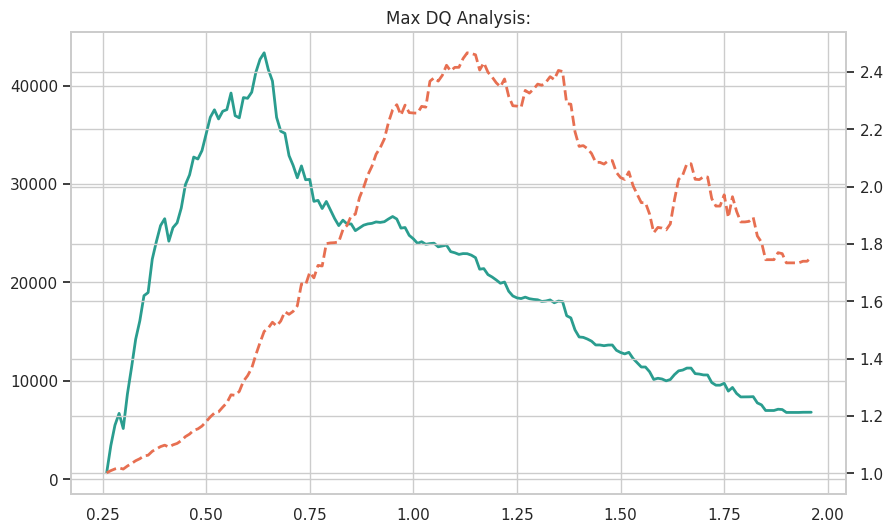

----------------------------------------
Refit Results:
Feature Count : 64
Validation IC : 0.093240  <-- 核心关注指标
Validation RMSE: 6.918705
----------------------------------------


In [368]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 63,
    'max_depth': 6,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.8, 
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'n_jobs': 4,
    'verbose': -1,
    'seed': 42
}
def retrain_with_selected_features(train_df, valid_df, selected_features, params=LGB_PARAMS, label_col='prj2_1_label'):
    """
    仅使用筛选后的 top_factors 进行重训并评估
    """
    print(f"========================================")
    print(f"开始重训 (Refitting) - 使用特征数: {len(selected_features)}")
    print(f"========================================")
    
    # 1. 构建精简版 Dataset
    # 注意：只传入 selected_features
    train_data = lgb.Dataset(
        train_df[selected_features], 
        label=train_df[label_col], 
        feature_name=selected_features
    )
    
    valid_data = lgb.Dataset(
        valid_df[selected_features], 
        label=valid_df[label_col], 
        feature_name=selected_features,
        reference=train_data 
    )
    
    # 2. 训练模型 (参数保持不变)
    # 注意：如果特征数特别少（例如<20个），feature_fraction=0.1 可能太小导致无法分裂
    # 但为了控制变量，这里先保持不变，除非报错或效果极差
    model = lgb.train(
        params,
        train_data,
        num_boost_round=300,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=20)
        ]
    )
    
    # 3. 评估效果
    print("\n>>> 正在评估重训模型性能...")
    
    # 预测验证集
    valid_preds = model.predict(valid_df[selected_features], num_iteration=model.best_iteration)
    # valid_preds = model.predict(valid_df[selected_features])
    valid_df['pred'] = valid_preds
    thresholds = np.arange(0.0, 10.0, 0.01)
    max_dq = -np.inf
    results = []
    for threshold in thresholds:
            buy_mask = valid_df['pred'] > threshold
            sell_mask = valid_df['pred'] <  -1*threshold
            pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label'] - (0.5/10000)*valid_df.loc[buy_mask,'LABEL_CAL_DQ_inst1_60']
            pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label'] - (0.5/10000)*valid_df.loc[sell_mask,'LABEL_CAL_DQ_inst1_60']
            # print(valid_df.loc[buy_mask,'LABEL_CAL_DQ_inst1_60'].sum(),valid_df.loc[sell_mask,'LABEL_CAL_DQ_inst1_60'].sum())
            # pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label']
            # pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label']
            DQ_buy = np.sum(pnl_buy_raw)
            DQ_sell = np.sum(pnl_sell_raw)
            # print(0.44*len(pnl_buy_raw),0.44*len(pnl_sell_raw),DQ_buy+DQ_sell)
            DQ = DQ_buy + DQ_sell
            count = len(pnl_buy_raw) + len(pnl_sell_raw)
            if count == 0:
                continue     
            final_DQ = 15 * DQ 
            if final_DQ > max_dq:
                max_dq = final_DQ
            abs_move = np.abs(pnl_buy_raw).sum() + np.abs(pnl_sell_raw).sum()
            dq_neg = (abs_move - DQ) / 2.0
            dq_pos = DQ + dq_neg
            dqr = dq_pos / dq_neg if dq_neg != 0 else 0
            results.append({
                'Threshold': threshold, 
                'DQ': final_DQ, 
                'DQR': dqr, 
                'Count': len(pnl_buy_raw) + len(pnl_sell_raw)
            })
    df_res = pd.DataFrame(results)
    df_res = df_res[(df_res['Count']>160)&(df_res['DQ']>0)]
    if not df_res.empty:
            sns.set_theme(style="whitegrid")
            fig, ax1 = plt.subplots(figsize=(10, 6))
            ax1.plot(df_res['Threshold'], df_res['DQ'], color='#2a9d8f', linewidth=2, label='DQ')
            ax2 = ax1.twinx()
            ax2.plot(df_res['Threshold'], df_res['DQR'], color='#e76f51', linestyle='--', linewidth=2, label='DQR')
            plt.title(f"Max DQ Analysis:")
            plt.show()
    # 计算 IC (Information Coefficient - 皮尔逊相关系数)
    # 这是量化中最看重的指标，代表预测值和真实值的排序相关性
    ic, p_value = pearsonr(valid_preds, valid_df[label_col].values)
    
    # 计算 RMSE
    mse = np.mean((valid_preds - valid_df[label_col].values) ** 2)
    rmse = np.sqrt(mse)
    
    print(f"----------------------------------------")
    print(f"Refit Results:")
    print(f"Feature Count : {len(selected_features)}")
    print(f"Validation IC : {ic:.6f}  <-- 核心关注指标")
    print(f"Validation RMSE: {rmse:.6f}")
    print(f"----------------------------------------")
    
    return model, {'ic': ic, 'rmse': rmse},df_res

# ================= 使用示例 =================

if __name__ == "__main__":
    # 假设你之前已经运行了筛选代码，并且有了 feature_imp DataFrame
    # 这里的 feature_imp 是你上一步得到的
    
    if True:
        train_df = pd.read_pickle("/home/zyyuan/project2/train_with_vae.pkl")
        valid_df = pd.read_pickle("/home/zyyuan/project2/valid_with_vae.pkl")
        # 1. 获取 Top Factors (例如 Top 50 或 累计贡献95%)
        # 策略: 取 Top 50 个最强特征
        top_n = 300
        imp_df = pd.read_csv("/home/zyyuan/project2/feature_importance.csv")
        top_factors = imp_df.head(top_n)['feature'].tolist()
        new_factors = imp_df['feature'].tolist()
        # 2. 只有这些特征进行重训
        final_model, metrics,df_res = retrain_with_selected_features(
            train_df, 
            valid_df, 
            [f'vae_latent_{i}' for i in range(64)],
            # top_factors,
            # [f'vae_latent_{i}' for i in range(64)]+['is_pm','is_am','is_night','gate_session_decay','gate_open_impulse'],
            # [f'market_latent_{i}' for i in range(16)]+[f'vae_latent_{i}' for i in range(64)], 
            # [f'market_latent_{i}' for i in range(64)],
            params=LGB_PARAMS
        )
        
        final_model.save_model(f'lgbm_top{top_n}_model.txt')

In [369]:
df_res[df_res['DQR']>=1.5]['DQ'].max()

np.float64(41636.95553837771)

In [370]:
df_res

Threshold           DQ       DQR  Count
26        0.26   627.246886  1.001671  10759
27        0.27  3390.292933  1.009223  10587
28        0.28  5469.128037  1.015171  10388
29        0.29  6668.350514  1.018803  10205
30        0.30  5130.353579  1.014697  10020
..         ...          ...       ...    ...
192       1.92  6765.238259  1.733898    166
193       1.93  6765.238259  1.733898    166
194       1.94  6782.178685  1.739479    164
195       1.95  6782.178685  1.739479    164
196       1.96  6786.885291  1.753284    161

[171 rows x 4 columns]

In [ ]:
context_factors = ['is_pm','is_am','is_night','gate_session_decay','gate_open_impulse','PSY_60','ret_kurt_120','amihud_ratio_60','ret_5min','ar_10','lower_bb','CV_30','rp_momentum_120','cvar_10','bigorder_pct']

In [ ]:
daily_data = pd.read_csv("/home/zyyuan/project1/try/market_data/20250512_SHFE_ag2506.csv")

In [ ]:
train_new['price_pos'].describe()

count    68157.000000
mean         0.500659
std          0.378278
min          0.000000
25%          0.111111
50%          0.500000
75%          0.875000
max          1.000000
Name: price_pos, dtype: float64

In [ ]:
res.loc['trend_10'],res_test.loc['trend_10']

(D1       -0.567165
 D2       -0.448648
 D3        0.281021
 D4       -0.391044
 D5        0.035375
 D6        0.272972
 D7             NaN
 D8             NaN
 D9             NaN
 D10            NaN
 Spread         NaN
 score          NaN
 Name: trend_10, dtype: float32,
 D1       -0.393538
 D2        0.088982
 D3        0.529202
 D4        0.784187
 D5        1.606916
 D6        2.270468
 D7             NaN
 D8             NaN
 D9             NaN
 D10            NaN
 Spread         NaN
 score          NaN
 Name: trend_10, dtype: float32)

In [ ]:
df_res

Threshold           DQ        DQR  Count
12        0.12   644.087922   1.001420  13009
13        0.13  2446.044862   1.005488  12824
14        0.14  7122.055235   1.016350  12639
15        0.15  7852.460748   1.018373  12436
16        0.16  9185.961651   1.021886  12265
..         ...          ...        ...    ...
532       5.32  9773.099713  12.676621     53
533       5.33  9773.099713  12.676621     53
534       5.34  9773.099713  12.676621     53
535       5.35  9948.803025  16.044838     52
536       5.36  9948.803025  16.044838     52

[525 rows x 4 columns]

In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 63,
    'max_depth': 6,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.8, 
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'n_jobs': 4,
    'verbose': -1,
    'seed': 42
}
def retrain_with_selected_features(train_df, valid_df, selected_features, params=LGB_PARAMS, label_col='prj2_1_label'):
    """
    仅使用筛选后的 top_factors 进行重训并评估
    """
    print(f"========================================")
    print(f"开始重训 (Refitting) - 使用特征数: {len(selected_features)}")
    print(f"========================================")
    
    # 1. 构建精简版 Dataset
    # 注意：只传入 selected_features
    train_data = lgb.Dataset(
        train_df[selected_features], 
        label=train_df[label_col], 
        feature_name=selected_features
    )
    
    valid_data = lgb.Dataset(
        valid_df[selected_features], 
        label=valid_df[label_col], 
        feature_name=selected_features,
        reference=train_data 
    )
    
    # 2. 训练模型 (参数保持不变)
    # 注意：如果特征数特别少（例如<20个），feature_fraction=0.1 可能太小导致无法分裂
    # 但为了控制变量，这里先保持不变，除非报错或效果极差
    model = lgb.train(
        params,
        train_data,
        num_boost_round=300,
        valid_sets=[valid_data],
        callbacks=[
            # lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=20)
        ]
    )
    
    # 3. 评估效果
    print("\n>>> 正在评估重训模型性能...")
    
    # 预测验证集
    # valid_preds = model.predict(valid_df[selected_features], num_iteration=model.best_iteration)
    valid_preds = model.predict(valid_df[selected_features])
    valid_df['factor_pred'] = valid_preds
    thresholds = np.arange(0.0, 10.0, 0.01)
    max_dq = -np.inf
    results = []
    for threshold in thresholds:
            buy_mask = valid_df['factor_pred'] > threshold
            sell_mask = valid_df['factor_pred'] <  -1*threshold
            pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label'] - (0.5/10000)*valid_df.loc[buy_mask,'LABEL_CAL_DQ_inst1_60']
            pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label'] - (0.5/10000)*valid_df.loc[sell_mask,'LABEL_CAL_DQ_inst1_60']
            # print(valid_df.loc[buy_mask,'LABEL_CAL_DQ_inst1_60'].sum(),valid_df.loc[sell_mask,'LABEL_CAL_DQ_inst1_60'].sum())
            # pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label']
            # pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label']
            DQ_buy = np.sum(pnl_buy_raw)
            DQ_sell = np.sum(pnl_sell_raw)
            # print(0.44*len(pnl_buy_raw),0.44*len(pnl_sell_raw),DQ_buy+DQ_sell)
            DQ = DQ_buy + DQ_sell
            count = len(pnl_buy_raw) + len(pnl_sell_raw)
            if count == 0:
                continue     
            final_DQ = 15 * DQ 
            if final_DQ > max_dq:
                max_dq = final_DQ
            abs_move = np.abs(pnl_buy_raw).sum() + np.abs(pnl_sell_raw).sum()
            dq_neg = (abs_move - DQ) / 2.0
            dq_pos = DQ + dq_neg
            dqr = dq_pos / dq_neg if dq_neg != 0 else 0
            results.append({
                'Threshold': threshold, 
                'DQ': final_DQ, 
                'DQR': dqr, 
                'Count': len(pnl_buy_raw) + len(pnl_sell_raw)
            })
    df_res = pd.DataFrame(results)
    df_res = df_res[(df_res['Count']>50)&(df_res['DQ']>0)]
    # if not df_res.empty:
    #         sns.set_theme(style="whitegrid")
    #         fig, ax1 = plt.subplots(figsize=(10, 6))
    #         ax1.plot(df_res['Threshold'], df_res['DQ'], color='#2a9d8f', linewidth=2, label='DQ')
    #         ax2 = ax1.twinx()
    #         ax2.plot(df_res['Threshold'], df_res['DQR'], color='#e76f51', linestyle='--', linewidth=2, label='DQR')
    #         plt.title(f"Max DQ Analysis:")
    #         plt.show()
    # 计算 IC (Information Coefficient - 皮尔逊相关系数)
    # 这是量化中最看重的指标，代表预测值和真实值的排序相关性
    ic, p_value = pearsonr(valid_preds, valid_df[label_col].values)
    
    # 计算 RMSE
    mse = np.mean((valid_preds - valid_df[label_col].values) ** 2)
    rmse = np.sqrt(mse)
    
    print(f"----------------------------------------")
    print(f"Refit Results:")
    print(f"Feature Count : {len(selected_features)}")
    print(f"Validation IC : {ic:.6f}  <-- 核心关注指标")
    print(f"Validation RMSE: {rmse:.6f}")
    print(f"----------------------------------------")
    
    return model, {'ic': ic, 'rmse': rmse},df_res

# ================= 使用示例 =================

if __name__ == "__main__":
    # 假设你之前已经运行了筛选代码，并且有了 feature_imp DataFrame
    # 这里的 feature_imp 是你上一步得到的
    factor_res = pd.DataFrame(columns = ['ic','maxDQ','maxDQ(DQR>=2)'])
    factorlist = factordata.columns[86:]
    for factor in factorlist:
        # train_df = pd.read_pickle("/home/zyyuan/project2/train_with_vae.pkl")
        # valid_df = pd.read_pickle("/home/zyyuan/project2/valid_with_vae.pkl")
        # 1. 获取 Top Factors (例如 Top 50 或 累计贡献95%)
        # 策略: 取 Top 50 个最强特征
        if factor in context_factors or (not np.issubdtype(train_new[factor].dtype, np.number)):
             continue
        top_n = 300
        imp_df = pd.read_csv("/home/zyyuan/project2/feature_importance.csv")
        top_factors = imp_df.head(top_n)['feature'].tolist()
        new_factors = imp_df['feature'].tolist()
        # 2. 只有这些特征进行重训
        final_model, metrics,df_res = retrain_with_selected_features(
            train_new, 
            valid_new, 
            # [f'vae_latent_{i}' for i in range(64)],
            # top_factors,
            [f'vae_latent_{i}' for i in range(64)]+context_factors+[factor],
            # [f'market_latent_{i}' for i in range(16)]+[f'vae_latent_{i}' for i in range(64)], 
            # [f'market_latent_{i}' for i in range(64)],
            params=LGB_PARAMS
        )
        factor_res.loc[factor] = [metrics['ic'],df_res['DQ'].max(),df_res[df_res['DQR']>=2]['DQ'].max()]

factor_res.sort_values(by = 'ic',ascending=False)
        

[260]	valid_0's rmse: 6.8679
[280]	valid_0's rmse: 6.86359
[300]	valid_0's rmse: 6.8607

>>> 正在评估重训模型性能...
----------------------------------------
Refit Results:
Feature Count : 80
Validation IC : 0.175908  <-- 核心关注指标
Validation RMSE: 6.860703
----------------------------------------
开始重训 (Refitting) - 使用特征数: 80
[20]	valid_0's rmse: 6.93419
[40]	valid_0's rmse: 6.92172
[60]	valid_0's rmse: 6.90983
[80]	valid_0's rmse: 6.90276
[100]	valid_0's rmse: 6.89791
[120]	valid_0's rmse: 6.89297
[140]	valid_0's rmse: 6.88884
[160]	valid_0's rmse: 6.88498
[180]	valid_0's rmse: 6.88218
[200]	valid_0's rmse: 6.87898
[220]	valid_0's rmse: 6.87905
[240]	valid_0's rmse: 6.8754
[260]	valid_0's rmse: 6.87474
[280]	valid_0's rmse: 6.8725
[300]	valid_0's rmse: 6.87119

>>> 正在评估重训模型性能...
----------------------------------------
Refit Results:
Feature Count : 80
Validation IC : 0.162722  <-- 核心关注指标
Validation RMSE: 6.871194
----------------------------------------
开始重训 (Refitting) - 使用特征数: 80
[20]	valid_0's

ic          maxDQ  maxDQ(DQR>=2)
ret_600            0.740754  694982.975245  694982.975245
tick100_ret        0.217459  116397.486083   89029.032906
amivest_lr_30      0.188941   71843.791967   59285.530681
netflow_5min       0.184955   71365.841648   51369.791564
weight_buysell_30  0.184769   68127.800921   54257.960454
...                     ...            ...            ...
hlc_ma_30          0.138330   66417.613707   30728.137522
upper_band         0.137999   63193.193623   37266.666026
realized_vol_60    0.136648   50947.877126   35473.682302
Ivol_30            0.127195   59169.418377   28406.034634
pvol_30min         0.117630   58557.122517   24247.224432

[225 rows x 3 columns]

In [ ]:
factor_res.sort_values(by = 'maxDQ(DQR>=2)',ascending=False)

ic          maxDQ  maxDQ(DQR>=2)
ret_600             0.740754  694982.975245  694982.975245
tick100_ret         0.217459  116397.486083   89029.032906
vol_entropy         0.182718   78424.474663   69654.145321
bigbuyvolpct_30min  0.174437   73182.431634   62409.150089
mfi_10m             0.178467   74587.019240   60645.189644
...                      ...            ...            ...
hlc_ma_30           0.138330   66417.613707   30728.137522
Ivol_30             0.127195   59169.418377   28406.034634
ES                  0.144425   73381.817248   26075.673882
effective_spread    0.144425   73381.817248   26075.673882
pvol_30min          0.117630   58557.122517   24247.224432

[225 rows x 3 columns]

In [ ]:
factorlist = factor_res.sort_values(by = 'maxDQ',ascending=False).index[2:50].tolist()

In [ ]:
factorlist

['PSY_60',
 'ret_kurt_120',
 'ES',
 'effective_spread',
 'hlc_ma_10',
 'oi_ret_corr_30',
 'br_30',
 'oi_ret_corr_10',
 'ret_kurt_30',
 'bigorder_vol_pct_5min',
 'ma20',
 'ar_10',
 'mfi_10m',
 'CV_30',
 'vr_30',
 'amihud_ratio_60',
 'OI_skew_120',
 'trend_10',
 'rp_momentum_120',
 'slope',
 'sq_return',
 'adtm_10m',
 'dollar_volume',
 'OI_std_300',
 'price_elascity',
 'kdj',
 'cci_30',
 'price_pos',
 'ab_nr_10m',
 'lower_bb',
 'OI_skew_600',
 'elasticity',
 'open',
 'vol_mid_corr_120',
 'SOIR_weighted',
 'SOIR4',
 'OFI5',
 'ret_5min',
 'SOIR',
 'sq_down_return',
 'down_variance_term',
 'channel_position',
 'OI_std_600',
 'cmo_10',
 'OI_std_120',
 'big_buy_volume',
 'is_reversal',
 'OFI4']


>>> Top 10 Feature Importance (gain):
              feature    importance  norm_importance
0   gate_open_impulse  1.451640e+06         0.062396
1  gate_session_decay  1.259828e+06         0.054151
2       vae_latent_55  5.956303e+05         0.025602
3       vae_latent_56  5.643020e+05         0.024255
4       vae_latent_42  5.433342e+05         0.023354
5       vae_latent_60  5.332250e+05         0.022920
6       vae_latent_34  5.237467e+05         0.022512
7       vae_latent_20  5.195176e+05         0.022330
8       vae_latent_37  5.047971e+05         0.021698
9       vae_latent_45  4.658968e+05         0.020026


/tmp/ipykernel_1963568/2716456640.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=imp_df.head(top_n), palette='viridis')


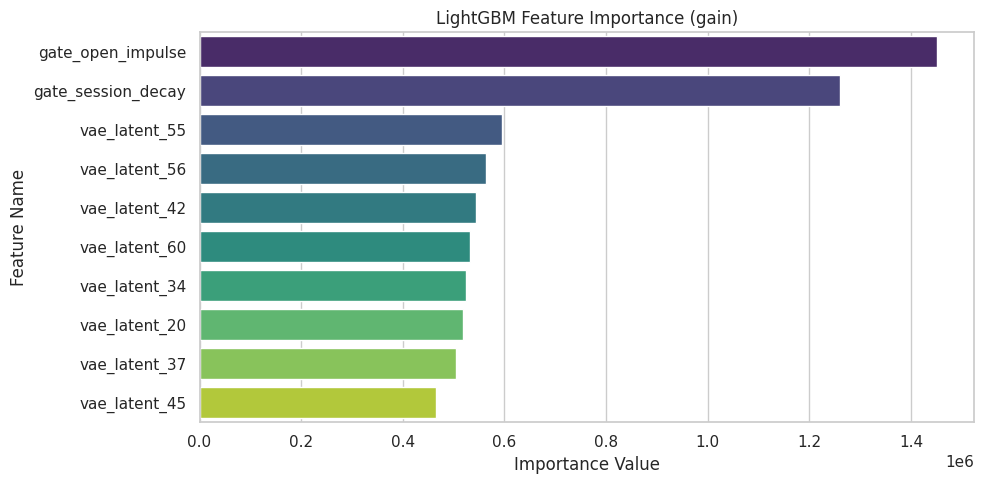

feature    importance  norm_importance
0    gate_open_impulse  1.451640e+06         0.062396
1   gate_session_decay  1.259828e+06         0.054151
2        vae_latent_55  5.956303e+05         0.025602
3        vae_latent_56  5.643020e+05         0.024255
4        vae_latent_42  5.433342e+05         0.023354
..                 ...           ...              ...
64        vae_latent_0  1.641320e+05         0.007055
65               is_pm  1.605300e+05         0.006900
66       vae_latent_14  1.497412e+05         0.006436
67       vae_latent_28  1.463105e+05         0.006289
68               is_am  1.389839e+05         0.005974

[69 rows x 3 columns]

In [ ]:
def show_feature_importance(model, importance_type='gain', top_n=10, plot=True):
    """
    提取并可视化 LightGBM 特征重要性
    Args:
        model: 训练好的 LGBM Booster 对象
        importance_type: 'gain' (增益, 推荐) 或 'split' (分裂次数)
        top_n: 显示前 N 个特征
        plot: 是否绘图
    Returns:
        pd.DataFrame: 包含特征名和重要性的 DataFrame
    """
    # 1. 获取特征名和重要性数值
    feature_names = model.feature_name()
    importance_values = model.feature_importance(importance_type=importance_type)
    
    # 2. 构建 DataFrame 并排序
    imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_values
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)
    
    # 3. 计算相对重要性 (百分比)
    imp_df['norm_importance'] = imp_df['importance'] / imp_df['importance'].sum()
    
    # 4. 打印 Top N
    print(f"\n>>> Top {top_n} Feature Importance ({importance_type}):")
    print(imp_df.head(top_n))
    
    # 5. 绘图
    if plot:
        plt.figure(figsize=(10, int(top_n * 0.5)))
        sns.barplot(x='importance', y='feature', data=imp_df.head(top_n), palette='viridis')
        plt.title(f'LightGBM Feature Importance ({importance_type})')
        plt.xlabel('Importance Value')
        plt.ylabel('Feature Name')
        plt.tight_layout()
        plt.show()
        
    return imp_df

show_feature_importance(final_model)

In [ ]:
final_model.feature_importance

<bound method Booster.feature_importance of <lightgbm.basic.Booster object at 0x7103609d73b0>>

In [ ]:
df_res

Threshold            DQ        DQR  Count
19        0.19     47.801290   1.000119  11620
20        0.20   2008.021922   1.005100  11417
21        0.21   3618.111485   1.009362  11239
22        0.22   2989.555710   1.007839  11075
23        0.23   3276.958696   1.008722  10902
..         ...           ...        ...    ...
571       5.71  13987.600616  13.034762     52
572       5.72  13930.403036  12.985550     51
573       5.73  13930.403036  12.985550     51
574       5.74  13930.403036  12.985550     51
575       5.75  13930.403036  12.985550     51

[557 rows x 4 columns]

In [ ]:
df_res[df_res['DQR']>=2]['DQ'].max()

np.float64(26689.513578493028)

In [ ]:
import pandas as pd
origin_data = pd.read_pickle("/home/zyyuan/project2/validdata_augmented_120_v2.pkl")
origin_data['is_pm']

0       -0.421423
1       -0.421423
2       -0.421423
3       -0.421423
4       -0.421423
           ...   
15062    2.372910
15063    2.372910
15064    2.372910
15065    2.372910
15066    2.372910
Name: is_pm, Length: 15067, dtype: float32

开始重训 (Refitting) - 使用特征数: 64
Training until validation scores don't improve for 50 rounds
[20]	valid_0's rmse: 6.93801
[40]	valid_0's rmse: 6.93122
[60]	valid_0's rmse: 6.92986
[80]	valid_0's rmse: 6.92726
[100]	valid_0's rmse: 6.92852
[120]	valid_0's rmse: 6.93013
Early stopping, best iteration is:
[71]	valid_0's rmse: 6.92636

>>> 正在评估重训模型性能...


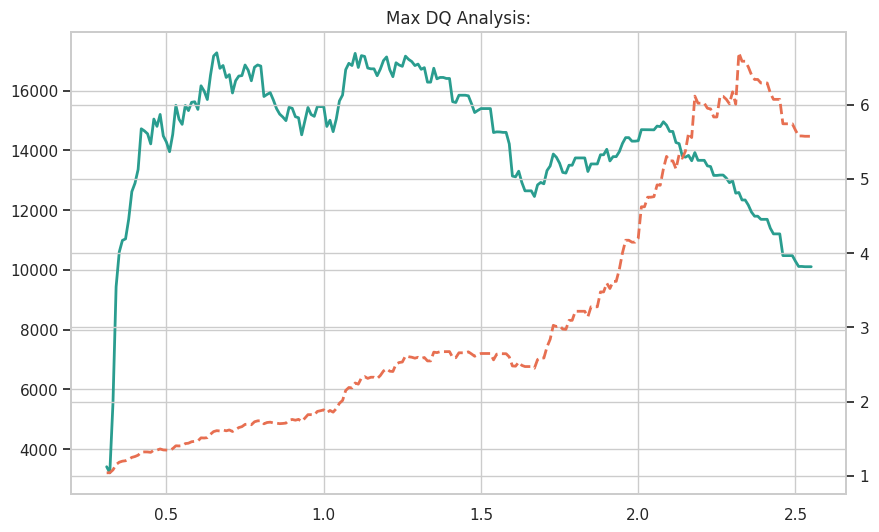

----------------------------------------
Refit Results:
Feature Count : 64
Validation IC : 0.084510  <-- 核心关注指标
Validation RMSE: 6.926356
----------------------------------------


In [387]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 63,
    'max_depth': 6,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.8, 
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'n_jobs': 4,
    'verbose': -1,
    'seed': 42
}
def retrain_with_selected_features(train_df, valid_df, selected_features, params=LGB_PARAMS, label_col='prj2_1_label'):
    """
    仅使用筛选后的 top_factors 进行重训并评估
    """
    print(f"========================================")
    print(f"开始重训 (Refitting) - 使用特征数: {len(selected_features)}")
    print(f"========================================")
    
    # 1. 构建精简版 Dataset
    # 注意：只传入 selected_features
    train_data = lgb.Dataset(
        train_df[selected_features], 
        label=train_df[label_col], 
        feature_name=selected_features
    )
    
    valid_data = lgb.Dataset(
        valid_df[selected_features], 
        label=valid_df[label_col], 
        feature_name=selected_features,
        reference=train_data 
    )
    
    # 2. 训练模型 (参数保持不变)
    # 注意：如果特征数特别少（例如<20个），feature_fraction=0.1 可能太小导致无法分裂
    # 但为了控制变量，这里先保持不变，除非报错或效果极差
    model = lgb.train(
        params,
        train_data,
        num_boost_round=2000,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=20)
        ]
    )
    
    # 3. 评估效果
    print("\n>>> 正在评估重训模型性能...")
    
    # 预测验证集
    valid_preds = model.predict(valid_df[selected_features], num_iteration=model.best_iteration)
    valid_df['market_pred'] = valid_preds
    thresholds = np.arange(0.0, 10.0, 0.01)
    max_dq = -np.inf
    results = []
    for threshold in thresholds:
            buy_mask = valid_df['market_pred'] > threshold
            sell_mask = valid_df['market_pred'] <  -1*threshold
            pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label'] - (0.5/10000)*valid_df.loc[buy_mask,'LABEL_CAL_DQ_inst1_60']
            pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label'] - (0.5/10000)*valid_df.loc[sell_mask,'LABEL_CAL_DQ_inst1_60']
            # print(valid_df.loc[buy_mask,'LABEL_CAL_DQ_inst1_60'].sum(),valid_df.loc[sell_mask,'LABEL_CAL_DQ_inst1_60'].sum())
            # pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label']
            # pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label']
            DQ_buy = np.sum(pnl_buy_raw)
            DQ_sell = np.sum(pnl_sell_raw)
            # print(0.44*len(pnl_buy_raw),0.44*len(pnl_sell_raw),DQ_buy+DQ_sell)
            DQ = DQ_buy + DQ_sell
            count = len(pnl_buy_raw) + len(pnl_sell_raw)
            if count == 0:
                continue     
            final_DQ = 15 * DQ 
            if final_DQ > max_dq:
                max_dq = final_DQ
            abs_move = np.abs(pnl_buy_raw).sum() + np.abs(pnl_sell_raw).sum()
            dq_neg = (abs_move - DQ) / 2.0
            dq_pos = DQ + dq_neg
            dqr = dq_pos / dq_neg if dq_neg != 0 else 0
            results.append({
                'Threshold': threshold, 
                'DQ': final_DQ, 
                'DQR': dqr, 
                'Count': len(pnl_buy_raw) + len(pnl_sell_raw)
            })
    df_res = pd.DataFrame(results)
    df_res = df_res[(df_res['Count']>50)&(df_res['DQ']>0)]
    if not df_res.empty:
            sns.set_theme(style="whitegrid")
            fig, ax1 = plt.subplots(figsize=(10, 6))
            ax1.plot(df_res['Threshold'], df_res['DQ'], color='#2a9d8f', linewidth=2, label='DQ')
            ax2 = ax1.twinx()
            ax2.plot(df_res['Threshold'], df_res['DQR'], color='#e76f51', linestyle='--', linewidth=2, label='DQR')
            plt.title(f"Max DQ Analysis:")
            plt.show()
    # 计算 IC (Information Coefficient - 皮尔逊相关系数)
    # 这是量化中最看重的指标，代表预测值和真实值的排序相关性
    ic, p_value = pearsonr(valid_preds, valid_df[label_col].values)
    
    # 计算 RMSE
    mse = np.mean((valid_preds - valid_df[label_col].values) ** 2)
    rmse = np.sqrt(mse)
    
    print(f"----------------------------------------")
    print(f"Refit Results:")
    print(f"Feature Count : {len(selected_features)}")
    print(f"Validation IC : {ic:.6f}  <-- 核心关注指标")
    print(f"Validation RMSE: {rmse:.6f}")
    print(f"----------------------------------------")
    
    return model, {'ic': ic, 'rmse': rmse},df_res

# ================= 使用示例 =================

if __name__ == "__main__":
    # 假设你之前已经运行了筛选代码，并且有了 feature_imp DataFrame
    # 这里的 feature_imp 是你上一步得到的
    
    if True:
        train_df = pd.read_pickle("/home/zyyuan/project2/train_with_vae_market.pkl")
        valid_df = pd.read_pickle("/home/zyyuan/project2/valid_with_vae_market.pkl")
        # 1. 获取 Top Factors (例如 Top 50 或 累计贡献95%)
        # 策略: 取 Top 50 个最强特征
        top_n = 300
        imp_df = pd.read_csv("/home/zyyuan/project2/feature_importance.csv")
        top_factors = imp_df.head(top_n)['feature'].tolist()
        new_factors = train_df.columns[-704:].tolist()
        # 2. 只有这些特征进行重训
        final_model, metrics,df_res = retrain_with_selected_features(
            train_df, 
            valid_df, 
            # [f'vae_latent_{i}' for i in range(64)]+['is_pm','is_am','is_night','gate_session_decay','gate_open_impulse'], 
            # [f'market_latent_{i}' for i in range(16)]+[f'vae_latent_{i}' for i in range(64)], 
            [f'market_latent_{i}' for i in range(64)],
            params=LGB_PARAMS
        )
        
        final_model.save_model(f'lgbm_top{top_n}_model.txt')

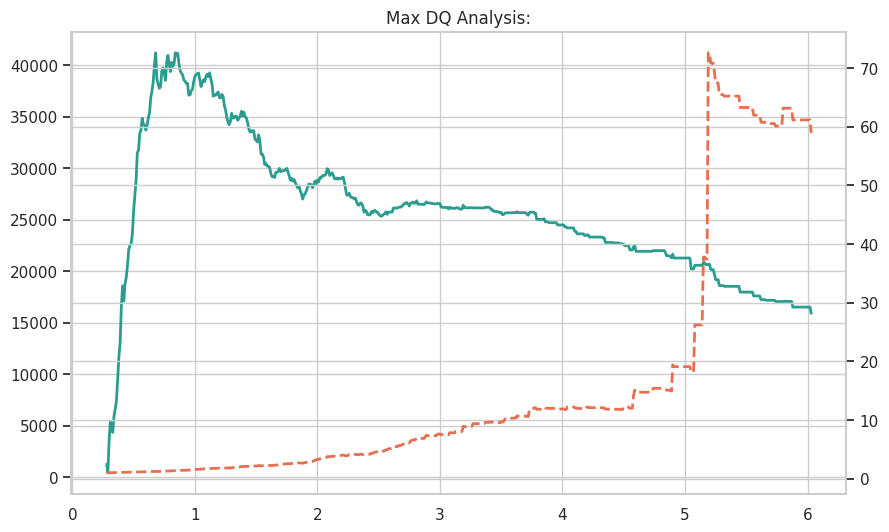

np.float64(0.17125125014095272)

In [ ]:
if True:
    valid_df['pred'] = 0.3*valid_df['market_pred']+valid_df['factor_pred']
    thresholds = np.arange(0.0, 10.0, 0.01)
    max_dq = -np.inf
    results = []
    for threshold in thresholds:
            buy_mask = valid_df['pred'] > threshold
            sell_mask = valid_df['pred'] <  -1*threshold
            pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label'] - (0.5/10000)*valid_df.loc[buy_mask,'LABEL_CAL_DQ_inst1_60']
            pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label'] - (0.5/10000)*valid_df.loc[sell_mask,'LABEL_CAL_DQ_inst1_60']
            # print(valid_df.loc[buy_mask,'LABEL_CAL_DQ_inst1_60'].sum(),valid_df.loc[sell_mask,'LABEL_CAL_DQ_inst1_60'].sum())
            # pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label']
            # pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label']
            DQ_buy = np.sum(pnl_buy_raw)
            DQ_sell = np.sum(pnl_sell_raw)
            # print(0.44*len(pnl_buy_raw),0.44*len(pnl_sell_raw),DQ_buy+DQ_sell)
            DQ = DQ_buy + DQ_sell
            count = len(pnl_buy_raw) + len(pnl_sell_raw)
            if count == 0:
                continue     
            final_DQ = 15 * DQ 
            if final_DQ > max_dq:
                max_dq = final_DQ
            abs_move = np.abs(pnl_buy_raw).sum() + np.abs(pnl_sell_raw).sum()
            dq_neg = (abs_move - DQ) / 2.0
            dq_pos = DQ + dq_neg
            dqr = dq_pos / dq_neg if dq_neg != 0 else 0
            results.append({
                'Threshold': threshold, 
                'DQ': final_DQ, 
                'DQR': dqr, 
                'Count': len(pnl_buy_raw) + len(pnl_sell_raw)
            })
    df_res = pd.DataFrame(results)
    df_res = df_res[(df_res['Count']>50)&(df_res['DQ']>0)]
    if not df_res.empty:
            sns.set_theme(style="whitegrid")
            fig, ax1 = plt.subplots(figsize=(10, 6))
            ax1.plot(df_res['Threshold'], df_res['DQ'], color='#2a9d8f', linewidth=2, label='DQ')
            ax2 = ax1.twinx()
            ax2.plot(df_res['Threshold'], df_res['DQR'], color='#e76f51', linestyle='--', linewidth=2, label='DQR')
            plt.title(f"Max DQ Analysis:")
            plt.show()
ic, p_value = pearsonr(valid_df['pred'], valid_df['prj2_1_label'].values)
ic

In [ ]:
train_df['ma]

Index(['f_10_1_mean', 'f_10_2_mean', 'f_10_3_mean', 'f_10_4_mean',
       'f_10_5_mean', 'f_10_6_mean', 'f_10_7_mean', 'f_11_1_mean',
       'f_11_2_mean', 'f_11_3_mean',
       ...
       'PSY_60', 'cci_30', 'amivest_lr_30', 'effective_depth_10min',
       'skew_overall_10m', 'regression_factor_10', 'oi_vol_corr_30',
       'rp_momentum_600', 'lower_band', 'net_inflow_min'],
      dtype='object', length=4703)

In [ ]:
df_res

Threshold            DQ       DQR  Count
10        0.10    131.294115  1.000283  13332
11        0.11   2863.516535  1.006280  13149
12        0.12   3029.960630  1.006740  12958
13        0.13   2635.835715  1.005953  12786
14        0.14   1707.030620  1.003902  12617
..         ...           ...       ...    ...
245       2.45  26603.381449  5.905103    165
246       2.46  26184.333855  5.827840    164
247       2.47  25999.382989  5.793739    163
248       2.48  25999.382989  5.793739    163
249       2.49  26348.103262  6.191855    161

[240 rows x 4 columns]

In [ ]:
dae_columns = [f'dae_latent_{i}' for i in range(64)]
vae_columns = [f'vae_latent_{i}' for i in range(32)]

In [ ]:
valid_df['prj2_1_label'].describe()

count    15067.000000
mean         0.044950
std          6.946887
min        -39.636920
25%         -3.243888
50%         -0.096340
75%          3.229092
max         70.831091
Name: prj2_1_label, dtype: float64

In [336]:
train_old = pd.read_pickle("/home/zyyuan/project2/validdata_augmented_120_v3.pkl")
train_new = pd.read_pickle("/home/zyyuan/project2/validdata_augmented_120_v4.pkl")

In [337]:
train_old.shape,train_new.shape

((15067, 4200), (15067, 4212))

In [ ]:
train_new[[x+'_abs' for x in context_factors]] = train_new[context_factors].abs()
valid_new[[x+'_abs' for x in context_factors]] = valid_new[context_factors].abs()

开始重训 (Refitting) - 使用特征数: 64
Training until validation scores don't improve for 50 rounds
[20]	valid_0's rmse: 6.93633
[40]	valid_0's rmse: 6.9287
[60]	valid_0's rmse: 6.92216
[80]	valid_0's rmse: 6.91816
[100]	valid_0's rmse: 6.91582
[120]	valid_0's rmse: 6.91339
[140]	valid_0's rmse: 6.91083
[160]	valid_0's rmse: 6.90895
[180]	valid_0's rmse: 6.9076
[200]	valid_0's rmse: 6.90601
[220]	valid_0's rmse: 6.90641
[240]	valid_0's rmse: 6.90606
Early stopping, best iteration is:
[194]	valid_0's rmse: 6.90526

>>> 正在评估重训模型性能...


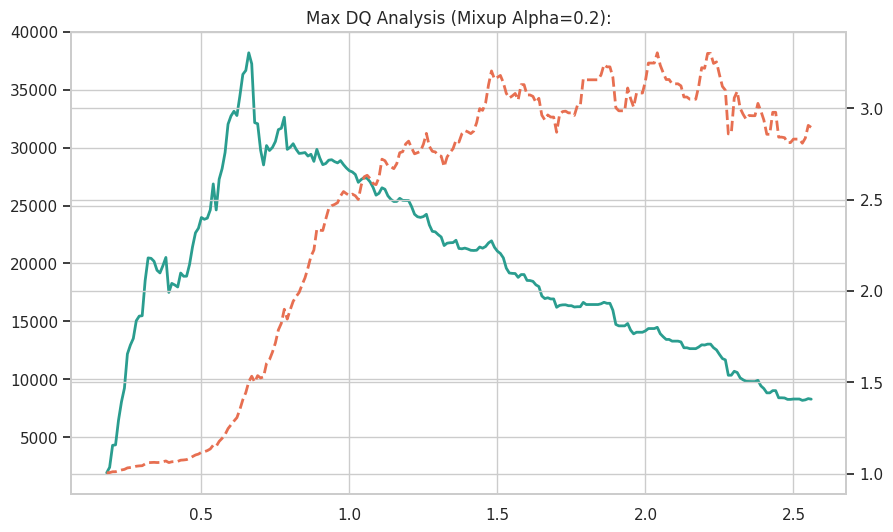

----------------------------------------
Refit Results (Mixup Alpha=0.2):
Feature Count : 64
Validation IC : 0.119089
Validation RMSE: 6.905259
----------------------------------------


In [388]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 63,
    'max_depth': 6,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.8, 
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'n_jobs': 4,
    'verbose': -1,
    'seed': 42
}

# =============================================================================
#  1. 新增：Mixup 数据增强函数
# =============================================================================
def mixup_dataframe(df, feature_cols, label_col, alpha=0.2, augment_ratio=1.0, seed=42):
    """
    对 DataFrame 进行 Mixup 增强
    Args:
        alpha: Beta分布参数 (推荐 0.1~0.4)
        augment_ratio: 增强数据量比例 (1.0 表示增加一倍数据)
    """
    if alpha <= 0 or augment_ratio <= 0:
        return df

    print(f">>> 执行 Mixup 增强 (alpha={alpha}, ratio={augment_ratio})...")
    np.random.seed(seed)
    
    # 提取数据矩阵
    X = df[feature_cols].values
    y = df[label_col].values
    n_samples = len(df)
    n_augment = int(n_samples * augment_ratio)
    
    # 随机索引
    idx_i = np.random.choice(n_samples, n_augment, replace=True) # 样本 A
    idx_j = np.random.permutation(idx_i)                         # 样本 B
    
    # 生成 Lambda (Beta 分布)
    lam = np.random.beta(alpha, alpha, size=n_augment)
    lam_x = lam.reshape(-1, 1) # 广播用于特征矩阵
    print(lam_x)
    # 线性插值
    X_new = lam_x * X[idx_i] + (1 - lam_x) * X[idx_j]
    y_new = lam * y[idx_i] + (1 - lam) * y[idx_j]
    
    # 构建新 DataFrame
    df_new = pd.DataFrame(X_new, columns=feature_cols)
    df_new[label_col] = y_new
    
    # 拼接 (Original + Mixup)
    df_aug = pd.concat([df[feature_cols + [label_col]], df_new], axis=0).reset_index(drop=True)
    
    print(f"    原始样本: {n_samples} -> 增强后: {len(df_aug)}")
    return df_aug
    # return df_new

# =============================================================================
#  2. 修改后的主训练函数
# =============================================================================
def retrain_with_selected_features(train_df, valid_df, selected_features, params=LGB_PARAMS, label_col='prj2_1_label', mixup_alpha=0.2):
    """
    仅使用筛选后的 top_factors 进行重训并评估 (集成了 Mixup)
    """
    print(f"========================================")
    print(f"开始重训 (Refitting) - 使用特征数: {len(selected_features)}")
    print(f"========================================")
    
    # --- [修改点]：在此处对训练集进行 Mixup 增强 ---
    # 仅增强 Train，绝不增强 Valid
    if mixup_alpha > 0:
        train_df_final = mixup_dataframe(
            train_df, 
            selected_features, 
            label_col, 
            alpha=mixup_alpha, 
            augment_ratio=0.0 # 默认增加一倍数据
        )
    else:
        train_df_final = train_df

    # 1. 构建精简版 Dataset
    # 注意：这里使用 train_df_final (可能是增强过的)
    train_data = lgb.Dataset(
        train_df_final[selected_features], 
        label=train_df_final[label_col], 
        feature_name=selected_features
    )
    
    # 验证集保持原样 valid_df
    valid_data = lgb.Dataset(
        valid_df[selected_features], 
        label=valid_df[label_col], 
        feature_name=selected_features,
        reference=train_data 
    )
    
    # 2. 训练模型 (参数保持不变)
    model = lgb.train(
        params,
        train_data,
        num_boost_round=300,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=20)
        ]
    )
    
    # 3. 评估效果 (保持原代码不变)
    print("\n>>> 正在评估重训模型性能...")
    
    # 预测验证集
    valid_preds = model.predict(valid_df[selected_features], num_iteration=model.best_iteration)
    # valid_preds = model.predict(valid_df[selected_features])
    valid_df['pred'] = valid_preds
    thresholds = np.arange(0.0, 10.0, 0.01)
    max_dq = -np.inf
    results = []
    
    for threshold in thresholds:
            buy_mask = valid_df['pred'] > threshold
            sell_mask = valid_df['pred'] <  -1*threshold
            pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label'] - (0.5/10000)*valid_df.loc[buy_mask,'LABEL_CAL_DQ_inst1_60']
            pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label'] - (0.5/10000)*valid_df.loc[sell_mask,'LABEL_CAL_DQ_inst1_60']
            # print(valid_df.loc[buy_mask,'LABEL_CAL_DQ_inst1_60'].sum(),valid_df.loc[sell_mask,'LABEL_CAL_DQ_inst1_60'].sum())
            # pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label']
            # pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label']
            DQ_buy = np.sum(pnl_buy_raw)
            DQ_sell = np.sum(pnl_sell_raw)
            # print(0.44*len(pnl_buy_raw),0.44*len(pnl_sell_raw),DQ_buy+DQ_sell)
            DQ = DQ_buy + DQ_sell
            count = len(pnl_buy_raw) + len(pnl_sell_raw)
            if count == 0:
                continue     
            final_DQ = 15 * DQ 
            if final_DQ > max_dq:
                max_dq = final_DQ
            abs_move = np.abs(pnl_buy_raw).sum() + np.abs(pnl_sell_raw).sum()
            dq_neg = (abs_move - DQ) / 2.0
            dq_pos = DQ + dq_neg
            dqr = dq_pos / dq_neg if dq_neg != 0 else 0
            results.append({
                'Threshold': threshold, 
                'DQ': final_DQ, 
                'DQR': dqr, 
                'Count': len(pnl_buy_raw) + len(pnl_sell_raw)
            })
    df_res = pd.DataFrame(results)
    df_res = df_res[(df_res['Count']>80)&(df_res['DQ']>0)]
    if not df_res.empty:
            sns.set_theme(style="whitegrid")
            fig, ax1 = plt.subplots(figsize=(10, 6))
            ax1.plot(df_res['Threshold'], df_res['DQ'], color='#2a9d8f', linewidth=2, label='DQ')
            ax2 = ax1.twinx()
            ax2.plot(df_res['Threshold'], df_res['DQR'], color='#e76f51', linestyle='--', linewidth=2, label='DQR')
            plt.title(f"Max DQ Analysis (Mixup Alpha={mixup_alpha}):")
            plt.show()
            
    # 计算 IC
    ic, p_value = pearsonr(valid_preds, valid_df[label_col].values)
    
    # 计算 RMSE
    mse = np.mean((valid_preds - valid_df[label_col].values) ** 2)
    rmse = np.sqrt(mse)
    
    print(f"----------------------------------------")
    print(f"Refit Results (Mixup Alpha={mixup_alpha}):")
    print(f"Feature Count : {len(selected_features)}")
    print(f"Validation IC : {ic:.6f}")
    print(f"Validation RMSE: {rmse:.6f}")
    print(f"----------------------------------------")
    
    return model, {'ic': ic, 'rmse': rmse},df_res

# ================= 使用示例 =================

if __name__ == "__main__":
    if True:
        # 假设 imp_df 和 train_df, valid_df 已经准备好
        # 这里为了演示，请确保路径和变量名与你实际环境一致
        top_n = 300
        imp_df = pd.read_csv("/home/zyyuan/project2/feature_importance.csv")
        top_factors = imp_df.head(top_n)['feature'].tolist()
        train_new = pd.read_pickle("/home/zyyuan/project2/train_with_vae_context.pkl")
        valid_new = pd.read_pickle("/home/zyyuan/project2/valid_with_vae_context.pkl")

        # 调用训练，开启 Mixup
        final_model, metrics,df_res = retrain_with_selected_features(
            train_new, 
            valid_new, 
            # [f'vae_latent_{i}' for i in range(64)]+['is_pm','is_am','is_night','gate_session_decay','gate_open_impulse'],
            [f'vae_latent_{i}' for i in range(64)],
            # top_factors,
            # factor_list+['is_pm','is_am','is_night','gate_session_decay','gate_open_impulse'],
            params=LGB_PARAMS,
            mixup_alpha=0.2  # 开启 Mixup，推荐 0.1 ~ 0.4
        )
        
        final_model.save_model(f'lgbm_mixup_top{top_n}_model.txt')

In [389]:
df_res[df_res['DQR']>=1.5]['DQ'].max()

np.float64(38197.39539517254)

In [391]:
df_res['Avg_pnl'] = (df_res['DQ'] / df_res['Count']) / 15
df_res

Threshold           DQ       DQR  Count   Avg_pnl
18        0.18  1913.044860  1.004437  12358  0.010320
19        0.19  2388.413703  1.005614  12189  0.013063
20        0.20  4285.446366  1.010215  12044  0.023721
21        0.21  4328.234956  1.010432  11909  0.024229
22        0.22  6456.062389  1.015776  11775  0.036552
..         ...          ...       ...    ...       ...
252       2.52  8287.474630  2.831199     86  6.424399
253       2.53  8171.191958  2.808764     84  6.485073
254       2.54  8215.539028  2.836609     83  6.598827
255       2.55  8322.924600  2.906381     82  6.766605
256       2.56  8274.189688  2.895218     81  6.810033

[239 rows x 5 columns]

In [ ]:
daily_data = pd.read_parquet("/home/zyyuan/project2/feature_generate_all_np_ag_v5_intern_parquet/ag2506_20250425_features.parquet")
daily_data.columns

In [ ]:
train_data = pd.read_pickle("/home/zyyuan/project2/traindata_augmented_120_v4.pkl")
train_data.columns[-30:]

Index(['f_93_98_mean', 'f_93_99_mean', 'f_9_1_mean', 'f_9_2_mean',
       'f_9_3_mean', 'f_9_4_mean', 'f_9_5_mean', 'f_9_6_mean', 'f_9_7_mean',
       'prj2_1_label', 'timestamp', 'trade_day', 'triggerInst.volume',
       'OBI_cum120', 'rolling_amp', 'LABEL_CAL_DQ_inst1_60', 'is_pm', 'is_am',
       'is_night', 'gate_session_decay', 'gate_open_impulse', 'gate_rv',
       'gate_downside_ratio', 'gate_rv_log', 'gate_range_log', 'delta_vol_1',
       'delta_vol_2', 'delta_vol_4', 'delta_vol_8', 'delta_vol_16'],
      dtype='object')

In [ ]:
train_data['gate_rv'].describe()

count    6.753600e+04
mean     1.807485e-09
std      1.000007e+00
min     -1.667165e+00
25%     -5.986390e-01
50%     -1.909562e-01
75%      3.676251e-01
max      1.795427e+01
Name: gate_rv, dtype: float64

In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 63,
    'max_depth': 6,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.8, 
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'n_jobs': 4,
    'verbose': -1,
    'seed': 42
}

# =============================================================================
#  1. 新增：Mixup 数据增强函数
# =============================================================================
def mixup_dataframe(df, feature_cols, label_col, alpha=0.2, augment_ratio=1.0, seed=42):
    """
    对 DataFrame 进行 Mixup 增强
    Args:
        alpha: Beta分布参数 (推荐 0.1~0.4)
        augment_ratio: 增强数据量比例 (1.0 表示增加一倍数据)
    """
    if alpha <= 0 or augment_ratio <= 0:
        return df

    print(f">>> 执行 Mixup 增强 (alpha={alpha}, ratio={augment_ratio})...")
    np.random.seed(seed)
    
    # 提取数据矩阵
    X = df[feature_cols].values
    y = df[label_col].values
    n_samples = len(df)
    n_augment = int(n_samples * augment_ratio)
    
    # 随机索引
    idx_i = np.random.choice(n_samples, n_augment, replace=True) # 样本 A
    idx_j = np.random.permutation(idx_i)                         # 样本 B
    
    # 生成 Lambda (Beta 分布)
    lam = np.random.beta(alpha, alpha, size=n_augment)
    lam_x = lam.reshape(-1, 1) # 广播用于特征矩阵
    print(lam_x)
    # 线性插值
    X_new = lam_x * X[idx_i] + (1 - lam_x) * X[idx_j]
    y_new = lam * y[idx_i] + (1 - lam) * y[idx_j]
    
    # 构建新 DataFrame
    df_new = pd.DataFrame(X_new, columns=feature_cols)
    df_new[label_col] = y_new
    
    # 拼接 (Original + Mixup)
    df_aug = pd.concat([df[feature_cols + [label_col]], df_new], axis=0).reset_index(drop=True)
    
    print(f"    原始样本: {n_samples} -> 增强后: {len(df_aug)}")
    return df_aug
    # return df_new

# =============================================================================
#  2. 修改后的主训练函数
# =============================================================================
def retrain_with_selected_features(train_df, valid_df, selected_features, params=LGB_PARAMS, label_col='prj2_1_label', mixup_alpha=0.2):
    """
    仅使用筛选后的 top_factors 进行重训并评估 (集成了 Mixup)
    """
    print(f"========================================")
    print(f"开始重训 (Refitting) - 使用特征数: {len(selected_features)}")
    print(f"========================================")
    
    # --- [修改点]：在此处对训练集进行 Mixup 增强 ---
    # 仅增强 Train，绝不增强 Valid
    if mixup_alpha > 0:
        train_df_final = mixup_dataframe(
            train_df, 
            selected_features, 
            label_col, 
            alpha=mixup_alpha, 
            augment_ratio=2.0 # 默认增加一倍数据
        )
    else:
        train_df_final = train_df

    # 1. 构建精简版 Dataset
    # 注意：这里使用 train_df_final (可能是增强过的)
    train_data = lgb.Dataset(
        train_df_final[selected_features], 
        label=train_df_final[label_col], 
        feature_name=selected_features
    )
    
    # 验证集保持原样 valid_df
    valid_data = lgb.Dataset(
        valid_df[selected_features], 
        label=valid_df[label_col], 
        feature_name=selected_features,
        reference=train_data 
    )
    
    # 2. 训练模型 (参数保持不变)
    model = lgb.train(
        params,
        train_data,
        num_boost_round=300,
        valid_sets=[valid_data],
        callbacks=[
            # lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=20)
        ]
    )
    
    # 3. 评估效果 (保持原代码不变)
    print("\n>>> 正在评估重训模型性能...")
    
    # 预测验证集
    # valid_preds = model.predict(valid_df[selected_features], num_iteration=model.best_iteration)
    valid_preds = model.predict(valid_df[selected_features])
    valid_df['pred'] = valid_preds
    thresholds = np.arange(0.0, 10.0, 0.01)
    max_dq = -np.inf
    results = []
    
    for threshold in thresholds:
            buy_mask = valid_df['pred'] > threshold
            sell_mask = valid_df['pred'] <  -1*threshold
            pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label'] - (0.5/10000)*valid_df.loc[buy_mask,'LABEL_CAL_DQ_inst1_60']
            pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label'] - (0.5/10000)*valid_df.loc[sell_mask,'LABEL_CAL_DQ_inst1_60']
            # print(valid_df.loc[buy_mask,'LABEL_CAL_DQ_inst1_60'].sum(),valid_df.loc[sell_mask,'LABEL_CAL_DQ_inst1_60'].sum())
            # pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label']
            # pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label']
            DQ_buy = np.sum(pnl_buy_raw)
            DQ_sell = np.sum(pnl_sell_raw)
            # print(0.44*len(pnl_buy_raw),0.44*len(pnl_sell_raw),DQ_buy+DQ_sell)
            DQ = DQ_buy + DQ_sell
            count = len(pnl_buy_raw) + len(pnl_sell_raw)
            if count == 0:
                continue     
            final_DQ = 15 * DQ 
            if final_DQ > max_dq:
                max_dq = final_DQ
            abs_move = np.abs(pnl_buy_raw).sum() + np.abs(pnl_sell_raw).sum()
            dq_neg = (abs_move - DQ) / 2.0
            dq_pos = DQ + dq_neg
            dqr = dq_pos / dq_neg if dq_neg != 0 else 0
            results.append({
                'Threshold': threshold, 
                'DQ': final_DQ, 
                'DQR': dqr, 
                'Count': len(pnl_buy_raw) + len(pnl_sell_raw)
            })
    df_res = pd.DataFrame(results)
    df_res = df_res[(df_res['Count']>160)&(df_res['DQ']>0)]
    # if not df_res.empty:
    #         sns.set_theme(style="whitegrid")
    #         fig, ax1 = plt.subplots(figsize=(10, 6))
    #         ax1.plot(df_res['Threshold'], df_res['DQ'], color='#2a9d8f', linewidth=2, label='DQ')
    #         ax2 = ax1.twinx()
    #         ax2.plot(df_res['Threshold'], df_res['DQR'], color='#e76f51', linestyle='--', linewidth=2, label='DQR')
    #         plt.title(f"Max DQ Analysis (Mixup Alpha={mixup_alpha}):")
    #         plt.show()
            
    # 计算 IC
    ic, p_value = pearsonr(valid_preds, valid_df[label_col].values)
    
    # 计算 RMSE
    mse = np.mean((valid_preds - valid_df[label_col].values) ** 2)
    rmse = np.sqrt(mse)
    
    print(f"----------------------------------------")
    print(f"Refit Results (Mixup Alpha={mixup_alpha}):")
    print(f"Feature Count : {len(selected_features)}")
    print(f"Validation IC : {ic:.6f}")
    print(f"Validation RMSE: {rmse:.6f}")
    print(f"----------------------------------------")
    
    return model, {'ic': ic, 'rmse': rmse},df_res

# ================= 使用示例 =================

if __name__ == "__main__":
    if True:
        # 假设 imp_df 和 train_df, valid_df 已经准备好
        # 这里为了演示，请确保路径和变量名与你实际环境一致
        top_n = 300
        imp_df = pd.read_csv("/home/zyyuan/project2/feature_importance.csv")
        top_factors = imp_df.head(top_n)['feature'].tolist()
        factor_res = pd.DataFrame(columns = ['ic','maxDQ','maxDQ(DQR>=2)'])
        factorlist = factordata.columns[86:]
        for factor in [x+'_abs' for x in context_factors]:
            if factor in context_factors or (not np.issubdtype(train_new[factor].dtype, np.number)):
                continue
            final_model, metrics,df_res = retrain_with_selected_features(
                train_new, 
                valid_new, 
                # [f'vae_latent_{i}' for i in range(64)]+['is_pm','is_am','is_night','gate_session_decay','gate_open_impulse'],
                [f'vae_latent_{i}' for i in range(64)]+[x for x in context_factors if x!= factor[:-4]]+[factor],
                # factor_list+['is_pm','is_am','is_night','gate_session_decay','gate_open_impulse'],
                params=LGB_PARAMS,
                mixup_alpha=0.2  # 开启 Mixup，推荐 0.1 ~ 0.4
            )
            factor_res.loc[factor] = [metrics['ic'],df_res['DQ'].max(),df_res[df_res['DQR']>=2]['DQ'].max()]

factor_res.sort_values(by = 'ic',ascending=False)

开始重训 (Refitting) - 使用特征数: 79
>>> 执行 Mixup 增强 (alpha=0.2, ratio=2.0)...
[[0.99976938]
 [0.84533603]
 [0.0635448 ]
 ...
 [1.        ]
 [0.99417778]
 [0.96555644]]
    原始样本: 68157 -> 增强后: 204471
[20]	valid_0's rmse: 6.93595
[40]	valid_0's rmse: 6.92474
[60]	valid_0's rmse: 6.91585
[80]	valid_0's rmse: 6.90926
[100]	valid_0's rmse: 6.90051
[120]	valid_0's rmse: 6.89152
[140]	valid_0's rmse: 6.8827
[160]	valid_0's rmse: 6.87928
[180]	valid_0's rmse: 6.8738
[200]	valid_0's rmse: 6.87263
[220]	valid_0's rmse: 6.87082
[240]	valid_0's rmse: 6.86617
[260]	valid_0's rmse: 6.86441
[280]	valid_0's rmse: 6.86122
[300]	valid_0's rmse: 6.86042

>>> 正在评估重训模型性能...
----------------------------------------
Refit Results (Mixup Alpha=0.2):
Feature Count : 79
Validation IC : 0.175183
Validation RMSE: 6.860422
----------------------------------------
开始重训 (Refitting) - 使用特征数: 79
>>> 执行 Mixup 增强 (alpha=0.2, ratio=2.0)...
[[0.99976938]
 [0.84533603]
 [0.0635448 ]
 ...
 [1.        ]
 [0.99417778]
 [0.96555644]]

ic         maxDQ  maxDQ(DQR>=2)
cvar_10_abs             0.198063  85722.568297   84880.161007
lower_bb_abs            0.192434  85416.892299   79932.354247
ar_10_abs               0.191594  83347.238606   77296.459244
CV_30_abs               0.188988  77805.623203   68669.301866
bigorder_pct_abs        0.188828  82985.898872   77604.893384
PSY_60_abs              0.187840  79325.631387   69964.268025
ret_kurt_120_abs        0.187313  78972.654111   67164.975445
gate_session_decay_abs  0.187057  84668.633485   77066.885631
ret_5min_abs            0.186082  79302.106484   73787.757245
amihud_ratio_60_abs     0.185585  80297.616714   72393.657076
rp_momentum_120_abs     0.184346  79667.526892   72060.222395
is_night_abs            0.181089  81005.730159   71295.431968
gate_open_impulse_abs   0.180695  78620.157052   68754.263998
is_am_abs               0.180532  80927.193765   72498.230143
is_pm_abs               0.175183  75192.519448   64634.288362

In [ ]:
factor_res.sort_values(by = 'maxDQ(DQR>=2)',ascending=False)

ic         maxDQ  maxDQ(DQR>=2)
cvar_10_abs             0.198063  85722.568297   84880.161007
lower_bb_abs            0.192434  85416.892299   79932.354247
bigorder_pct_abs        0.188828  82985.898872   77604.893384
ar_10_abs               0.191594  83347.238606   77296.459244
gate_session_decay_abs  0.187057  84668.633485   77066.885631
ret_5min_abs            0.186082  79302.106484   73787.757245
is_am_abs               0.180532  80927.193765   72498.230143
amihud_ratio_60_abs     0.185585  80297.616714   72393.657076
rp_momentum_120_abs     0.184346  79667.526892   72060.222395
is_night_abs            0.181089  81005.730159   71295.431968
PSY_60_abs              0.187840  79325.631387   69964.268025
gate_open_impulse_abs   0.180695  78620.157052   68754.263998
CV_30_abs               0.188988  77805.623203   68669.301866
ret_kurt_120_abs        0.187313  78972.654111   67164.975445
is_pm_abs               0.175183  75192.519448   64634.288362

In [ ]:
data_all['cvar_10'].describe()

count    82459.000000
mean        -0.000361
std          0.000337
min         -0.008603
25%         -0.000441
50%         -0.000318
75%         -0.000217
max          0.000106
Name: cvar_10, dtype: float64

In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 63,
    'max_depth': 6,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.8, 
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'n_jobs': 4,
    'verbose': -1,
    'seed': 42
}

# =============================================================================
#  1. 新增：Mixup 数据增强函数
# =============================================================================
def mixup_dataframe(df, feature_cols, label_col, alpha=0.2, augment_ratio=1.0, seed=42):
    """
    对 DataFrame 进行 Mixup 增强
    Args:
        alpha: Beta分布参数 (推荐 0.1~0.4)
        augment_ratio: 增强数据量比例 (1.0 表示增加一倍数据)
    """
    if alpha <= 0 or augment_ratio <= 0:
        return df

    print(f">>> 执行 Mixup 增强 (alpha={alpha}, ratio={augment_ratio})...")
    np.random.seed(seed)
    
    # 提取数据矩阵
    X = df[feature_cols].values
    y = df[label_col].values
    n_samples = len(df)
    n_augment = int(n_samples * augment_ratio)
    
    # 随机索引
    idx_i = np.random.choice(n_samples, n_augment, replace=True) # 样本 A
    idx_j = np.random.permutation(idx_i)                         # 样本 B
    
    # 生成 Lambda (Beta 分布)
    lam = np.random.beta(alpha, alpha, size=n_augment)
    lam_x = lam.reshape(-1, 1) # 广播用于特征矩阵
    print(lam_x)
    # 线性插值
    X_new = lam_x * X[idx_i] + (1 - lam_x) * X[idx_j]
    y_new = lam * y[idx_i] + (1 - lam) * y[idx_j]
    
    # 构建新 DataFrame
    df_new = pd.DataFrame(X_new, columns=feature_cols)
    df_new[label_col] = y_new
    
    # 拼接 (Original + Mixup)
    df_aug = pd.concat([df[feature_cols + [label_col]], df_new], axis=0).reset_index(drop=True)
    
    print(f"    原始样本: {n_samples} -> 增强后: {len(df_aug)}")
    return df_aug
    # return df_new

# =============================================================================
#  2. 修改后的主训练函数
# =============================================================================
def retrain_with_selected_features(train_df, valid_df, selected_features, params=LGB_PARAMS, label_col='prj2_1_label', mixup_alpha=0.2):
    """
    仅使用筛选后的 top_factors 进行重训并评估 (集成了 Mixup)
    """
    print(f"========================================")
    print(f"开始重训 (Refitting) - 使用特征数: {len(selected_features)}")
    print(f"========================================")
    
    # --- [修改点]：在此处对训练集进行 Mixup 增强 ---
    # 仅增强 Train，绝不增强 Valid
    if mixup_alpha > 0:
        train_df_final = mixup_dataframe(
            train_df, 
            selected_features, 
            label_col, 
            alpha=mixup_alpha, 
            augment_ratio=2.0 # 默认增加一倍数据
        )
    else:
        train_df_final = train_df

    # 1. 构建精简版 Dataset
    # 注意：这里使用 train_df_final (可能是增强过的)
    train_data = lgb.Dataset(
        train_df_final[selected_features], 
        label=train_df_final[label_col], 
        feature_name=selected_features
    )
    
    # 验证集保持原样 valid_df
    valid_data = lgb.Dataset(
        valid_df[selected_features], 
        label=valid_df[label_col], 
        feature_name=selected_features,
        reference=train_data 
    )
    
    # 2. 训练模型 (参数保持不变)
    model = lgb.train(
        params,
        train_data,
        num_boost_round=300,
        valid_sets=[valid_data],
        callbacks=[
            # lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=20)
        ]
    )
    
    # 3. 评估效果 (保持原代码不变)
    print("\n>>> 正在评估重训模型性能...")
    
    # 预测验证集
    # valid_preds = model.predict(valid_df[selected_features], num_iteration=model.best_iteration)
    valid_preds = model.predict(valid_df[selected_features])
    valid_df['pred'] = valid_preds
    thresholds = np.arange(0.0, 10.0, 0.01)
    max_dq = -np.inf
    results = []
    
    for threshold in thresholds:
            buy_mask = valid_df['pred'] > threshold
            sell_mask = valid_df['pred'] <  -1*threshold
            pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label'] - (0.5/10000)*valid_df.loc[buy_mask,'LABEL_CAL_DQ_inst1_60']
            pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label'] - (0.5/10000)*valid_df.loc[sell_mask,'LABEL_CAL_DQ_inst1_60']
            # print(valid_df.loc[buy_mask,'LABEL_CAL_DQ_inst1_60'].sum(),valid_df.loc[sell_mask,'LABEL_CAL_DQ_inst1_60'].sum())
            # pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label']
            # pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label']
            DQ_buy = np.sum(pnl_buy_raw)
            DQ_sell = np.sum(pnl_sell_raw)
            # print(0.44*len(pnl_buy_raw),0.44*len(pnl_sell_raw),DQ_buy+DQ_sell)
            DQ = DQ_buy + DQ_sell
            count = len(pnl_buy_raw) + len(pnl_sell_raw)
            if count == 0:
                continue     
            final_DQ = 15 * DQ 
            if final_DQ > max_dq:
                max_dq = final_DQ
            abs_move = np.abs(pnl_buy_raw).sum() + np.abs(pnl_sell_raw).sum()
            dq_neg = (abs_move - DQ) / 2.0
            dq_pos = DQ + dq_neg
            dqr = dq_pos / dq_neg if dq_neg != 0 else 0
            results.append({
                'Threshold': threshold, 
                'DQ': final_DQ, 
                'DQR': dqr, 
                'Count': len(pnl_buy_raw) + len(pnl_sell_raw)
            })
    df_res = pd.DataFrame(results)
    df_res = df_res[(df_res['Count']>160)&(df_res['DQ']>0)]
    # if not df_res.empty:
    #         sns.set_theme(style="whitegrid")
    #         fig, ax1 = plt.subplots(figsize=(10, 6))
    #         ax1.plot(df_res['Threshold'], df_res['DQ'], color='#2a9d8f', linewidth=2, label='DQ')
    #         ax2 = ax1.twinx()
    #         ax2.plot(df_res['Threshold'], df_res['DQR'], color='#e76f51', linestyle='--', linewidth=2, label='DQR')
    #         plt.title(f"Max DQ Analysis (Mixup Alpha={mixup_alpha}):")
    #         plt.show()
            
    # 计算 IC
    ic, p_value = pearsonr(valid_preds, valid_df[label_col].values)
    
    # 计算 RMSE
    mse = np.mean((valid_preds - valid_df[label_col].values) ** 2)
    rmse = np.sqrt(mse)
    
    print(f"----------------------------------------")
    print(f"Refit Results (Mixup Alpha={mixup_alpha}):")
    print(f"Feature Count : {len(selected_features)}")
    print(f"Validation IC : {ic:.6f}")
    print(f"Validation RMSE: {rmse:.6f}")
    print(f"----------------------------------------")
    
    return model, {'ic': ic, 'rmse': rmse},df_res

# ================= 使用示例 =================

if __name__ == "__main__":
    if True:
        # 假设 imp_df 和 train_df, valid_df 已经准备好
        # 这里为了演示，请确保路径和变量名与你实际环境一致
        top_n = 300
        imp_df = pd.read_csv("/home/zyyuan/project2/feature_importance.csv")
        top_factors = imp_df.head(top_n)['feature'].tolist()
        factor_test = pd.DataFrame(columns = ['ic','maxDQ','maxDQ(DQR>=2)'])
        factorlist = factordata.columns[86:]
        for factor in context_factors:
            final_model, metrics,df_res = retrain_with_selected_features(
                train_new, 
                valid_new, 
                # [f'vae_latent_{i}' for i in range(64)]+['is_pm','is_am','is_night','gate_session_decay','gate_open_impulse'],
                [f'vae_latent_{i}' for i in range(64)]+[x for x in context_factors if x != factor],
                # factor_list+['is_pm','is_am','is_night','gate_session_decay','gate_open_impulse'],
                params=LGB_PARAMS,
                mixup_alpha=0.2  # 开启 Mixup，推荐 0.1 ~ 0.4
            )
            factor_test.loc[factor] = [metrics['ic'],df_res['DQ'].max(),df_res[df_res['DQR']>=2]['DQ'].max()]

factor_test.sort_values(by = 'ic',ascending=False)

开始重训 (Refitting) - 使用特征数: 64
>>> 执行 Mixup 增强 (alpha=0.2, ratio=2.0)...
[[0.99976938]
 [0.84533603]
 [0.0635448 ]
 ...
 [1.        ]
 [0.99417778]
 [0.96555644]]
    原始样本: 68157 -> 增强后: 204471
[20]	valid_0's rmse: 6.93502
[40]	valid_0's rmse: 6.92737
[60]	valid_0's rmse: 6.92247
[80]	valid_0's rmse: 6.91864
[100]	valid_0's rmse: 6.91373
[120]	valid_0's rmse: 6.90972
[140]	valid_0's rmse: 6.90804
[160]	valid_0's rmse: 6.9066
[180]	valid_0's rmse: 6.90464
[200]	valid_0's rmse: 6.90426
[220]	valid_0's rmse: 6.90224
[240]	valid_0's rmse: 6.89991
[260]	valid_0's rmse: 6.89713
[280]	valid_0's rmse: 6.89681
[300]	valid_0's rmse: 6.89624

>>> 正在评估重训模型性能...
----------------------------------------
Refit Results (Mixup Alpha=0.2):
Feature Count : 64
Validation IC : 0.127383
Validation RMSE: 6.896236
----------------------------------------
开始重训 (Refitting) - 使用特征数: 64
>>> 执行 Mixup 增强 (alpha=0.2, ratio=2.0)...
[[0.99976938]
 [0.84533603]
 [0.0635448 ]
 ...
 [1.        ]
 [0.99417778]
 [0.96555644]

KeyboardInterrupt: 

In [ ]:
factor_test.sort_values(by = 'maxDQ(DQR>=2)',ascending=False)

ic         maxDQ  maxDQ(DQR>=2)
ar_10               0.186985  75232.959768   68203.960578
cvar_10             0.184557  78643.501341   65215.497038
lower_bb            0.188852  71986.642218   65124.892317
is_pm               0.187631  75763.085303   64828.629067
gate_open_impulse   0.182619  71091.569731   64815.913589
ret_5min            0.186225  73123.787870   64552.286865
is_am               0.185284  79572.232041   63360.340432
bigorder_pct        0.183932  72641.880072   63134.959102
CV_30               0.189391  71430.814812   62378.170842
is_night            0.183990  76402.352028   62052.807026
amihud_ratio_60     0.176238  70568.490259   58788.914528
rp_momentum_120     0.182148  64114.921765   57487.751067
gate_session_decay  0.176461  73070.091011   56863.950571
PSY_60              0.185776  63381.618342   56602.620614
ret_kurt_120        0.185342  54673.959196   42663.676297

In [ ]:
for factor in factor_list:
    final_model, metrics,df_res = retrain_with_selected_features(
                train_new, 
                valid_new, 
                [f'vae_latent_{i}' for i in range(64)]+['is_pm','is_am','is_night','gate_session_decay','gate_open_impulse',factor],
                # factor_list+['is_pm','is_am','is_night','gate_session_decay','gate_open_impulse'],
                params=LGB_PARAMS,
                mixup_alpha=0.2  # 开启 Mixup，推荐 0.1 ~ 0.4
            )

In [ ]:
factor_list

['adtm_30m',
 'coppock_10_15_30m',
 'rsj_30',
 'TrendStrenth_30',
 'ar_30',
 'macd_long',
 'rsi_long',
 'cmo_30',
 'mfi_30m',
 'upper_bb',
 'variance_diff_30m',
 'pv_corr_10',
 'OI_MA_600',
 'netflow_30min',
 'PSY_60',
 'cci_30',
 'amivest_lr_30',
 'effective_depth_10min',
 'skew_overall_10m',
 'regression_factor_10',
 'oi_vol_corr_30',
 'rp_momentum_600',
 'lower_band',
 'net_inflow_min']

开始重训 (Refitting) - 使用特征数: 64
>>> 执行 Sign Flipping 增强 (ratio=1.0)...
    原始样本: 68157 -> 翻转增强后: 136314 (Added -X,-Y samples)
>>> 执行 Mixup 增强 (alpha=0.3, ratio=3.0)...
    原始样本: 136314 -> 增强后: 545256
Training until validation scores don't improve for 50 rounds
[20]	valid_0's rmse: 6.93938
[40]	valid_0's rmse: 6.93259
[60]	valid_0's rmse: 6.92924
[80]	valid_0's rmse: 6.92792
[100]	valid_0's rmse: 6.92577
[120]	valid_0's rmse: 6.92292
[140]	valid_0's rmse: 6.92072
[160]	valid_0's rmse: 6.91884
[180]	valid_0's rmse: 6.91729
[200]	valid_0's rmse: 6.91704
[220]	valid_0's rmse: 6.91726
[240]	valid_0's rmse: 6.91701
[260]	valid_0's rmse: 6.91485
[280]	valid_0's rmse: 6.91366
[300]	valid_0's rmse: 6.91439
[320]	valid_0's rmse: 6.91215
[340]	valid_0's rmse: 6.91139
[360]	valid_0's rmse: 6.91246
[380]	valid_0's rmse: 6.91278
Early stopping, best iteration is:
[343]	valid_0's rmse: 6.91086

>>> 正在评估重训模型性能...


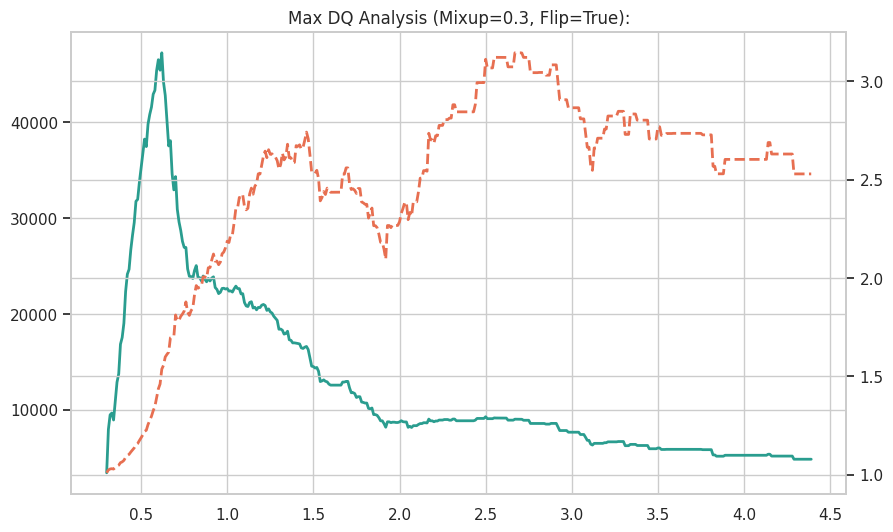

----------------------------------------
Refit Results (Mixup=0.3, Flip=True):
Feature Count : 64
Validation IC : 0.106151
Validation RMSE: 6.910859
----------------------------------------


In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 63,
    'max_depth': 6,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.8, 
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'n_jobs': 4,
    'verbose': -1,
    'seed': 42
}

# =============================================================================
#  1. 新增：Mixup 数据增强函数 (保持不变)
# =============================================================================
def mixup_dataframe(df, feature_cols, label_col, alpha=0.2, augment_ratio=1.0, seed=42):
    """
    对 DataFrame 进行 Mixup 增强
    """
    if alpha <= 0 or augment_ratio <= 0:
        return df

    print(f">>> 执行 Mixup 增强 (alpha={alpha}, ratio={augment_ratio})...")
    np.random.seed(seed)
    
    # 提取数据矩阵
    X = df[feature_cols].values
    y = df[label_col].values
    n_samples = len(df)
    n_augment = int(n_samples * augment_ratio)
    
    # 随机索引
    idx_i = np.random.choice(n_samples, n_augment, replace=True) # 样本 A
    idx_j = np.random.permutation(idx_i)                         # 样本 B
    
    # 生成 Lambda (Beta 分布)
    lam = np.random.beta(alpha, alpha, size=n_augment)
    lam_x = lam.reshape(-1, 1) # 广播用于特征矩阵
    
    # 线性插值
    X_new = lam_x * X[idx_i] + (1 - lam_x) * X[idx_j]
    y_new = lam * y[idx_i] + (1 - lam) * y[idx_j]
    
    # 构建新 DataFrame
    df_new = pd.DataFrame(X_new, columns=feature_cols)
    df_new[label_col] = y_new
    
    # 拼接 (Original + Mixup)
    df_aug = pd.concat([df[feature_cols + [label_col]], df_new], axis=0).reset_index(drop=True)
    
    print(f"    原始样本: {n_samples} -> 增强后: {len(df_aug)}")
    return df_aug

# =============================================================================
#  [新增] 2. 对称翻转增强函数 (Sign Flipping)
# =============================================================================
def apply_sign_flip(df, feature_cols, label_col, flip_ratio=0.5, seed=42):
    """
    对随机选中的样本进行特征和标签取反 (-X, -Y) 并添加到训练集中
    注意：这要求特征具有对称性（如标准化后的因子、收益率）。
    如果是价格或成交量等非负指标，直接取反可能没有物理意义。
    """
    if flip_ratio <= 0:
        return df
        
    print(f">>> 执行 Sign Flipping 增强 (ratio={flip_ratio})...")
    np.random.seed(seed)
    
    n_samples = len(df)
    n_flip = int(n_samples * flip_ratio)
    
    # 随机选择要翻转的样本索引
    flip_indices = np.random.choice(n_samples, n_flip, replace=False)
    
    # 提取副本
    df_flip = df.iloc[flip_indices].copy()
    
    # 核心操作：X -> -X, Y -> -Y
    df_flip[feature_cols] = df_flip[feature_cols] * -1
    df_flip[label_col] = df_flip[label_col] * -1
    
    # 拼接 (Original + Flipped)
    df_final = pd.concat([df, df_flip], axis=0).reset_index(drop=True)
    
    print(f"    原始样本: {n_samples} -> 翻转增强后: {len(df_final)} (Added -X,-Y samples)")
    return df_final

# =============================================================================
#  3. 修改后的主训练函数
# =============================================================================
def retrain_with_selected_features(train_df, valid_df, selected_features, params=LGB_PARAMS, label_col='prj2_1_label', mixup_alpha=0.2, enable_sign_flip=False):
    """
    仅使用筛选后的 top_factors 进行重训并评估 (集成了 Mixup 和 Sign Flip)
    Args:
        enable_sign_flip (bool): 是否开启对称翻转增强
    """
    print(f"========================================")
    print(f"开始重训 (Refitting) - 使用特征数: {len(selected_features)}")
    print(f"========================================")
    
    # 复制一份以防修改原始数据
    train_df_curr = train_df.copy()

    # --- [新增逻辑] 1. Sign Flipping (如果开启) ---
    # 通常建议在 Mixup 之前做，这样 Mixup 也可以在正向和反向样本间插值
    if enable_sign_flip:
        train_df_curr = apply_sign_flip(
            train_df_curr, 
            selected_features, 
            label_col, 
            flip_ratio=1.0 # 默认对 50% 的数据进行翻转扩充
        )

    # --- [原有逻辑] 2. Mixup 增强 ---
    if mixup_alpha > 0:
        train_df_final = mixup_dataframe(
            train_df_curr, 
            selected_features, 
            label_col, 
            alpha=mixup_alpha, 
            augment_ratio=3.0 # 默认增加数据
        )
    else:
        train_df_final = train_df_curr

    # 1. 构建精简版 Dataset
    train_data = lgb.Dataset(
        train_df_final[selected_features], 
        label=train_df_final[label_col], 
        feature_name=selected_features
    )
    
    # 验证集保持原样 valid_df
    valid_data = lgb.Dataset(
        valid_df[selected_features], 
        label=valid_df[label_col], 
        feature_name=selected_features,
        reference=train_data 
    )
    
    # 2. 训练模型 (参数保持不变)
    model = lgb.train(
        params,
        train_data,
        num_boost_round=2000,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=20)
        ]
    )
    
    # 3. 评估效果 (保持原代码不变)
    print("\n>>> 正在评估重训模型性能...")
    
    # 预测验证集
    valid_preds = model.predict(valid_df[selected_features], num_iteration=model.best_iteration)
    valid_df['pred'] = valid_preds
    thresholds = np.arange(0.0, 10.0, 0.01)
    max_dq = -np.inf
    results = []
    
    # --- 以下逻辑完全保持不变 ---
    for threshold in thresholds:
            buy_mask = valid_df['pred'] > threshold
            sell_mask = valid_df['pred'] <  -1*threshold
            pnl_buy_raw = valid_df.loc[buy_mask,'prj2_1_label']
            pnl_sell_raw = -1*valid_df.loc[sell_mask,'prj2_1_label']
            DQ_buy = np.sum(pnl_buy_raw) - 0.44*len(pnl_buy_raw)
            DQ_sell = np.sum(pnl_sell_raw) - 0.44*len(pnl_sell_raw)
            
            DQ = DQ_buy + DQ_sell
            count = len(pnl_buy_raw) + len(pnl_sell_raw)
            if count == 0:
                continue    
            final_DQ = 15 * DQ 
            if final_DQ > max_dq:
                max_dq = final_DQ
            abs_move = np.abs(pnl_buy_raw).sum() + np.abs(pnl_sell_raw).sum()
            dq_neg = (abs_move - DQ) / 2.0
            dq_pos = DQ + dq_neg
            dqr = dq_pos / dq_neg if dq_neg != 0 else 0
            results.append({
                'Threshold': threshold, 
                'DQ': final_DQ, 
                'DQR': dqr, 
                'Count': len(pnl_buy_raw) + len(pnl_sell_raw)
            })
            
    df_res = pd.DataFrame(results)
    df_res = df_res[(df_res['Count']>50)&(df_res['DQ']>0)]
    if not df_res.empty:
            sns.set_theme(style="whitegrid")
            fig, ax1 = plt.subplots(figsize=(10, 6))
            ax1.plot(df_res['Threshold'], df_res['DQ'], color='#2a9d8f', linewidth=2, label='DQ')
            ax2 = ax1.twinx()
            ax2.plot(df_res['Threshold'], df_res['DQR'], color='#e76f51', linestyle='--', linewidth=2, label='DQR')
            plt.title(f"Max DQ Analysis (Mixup={mixup_alpha}, Flip={enable_sign_flip}):")
            plt.show()
            
    # 计算 IC
    ic, p_value = pearsonr(valid_preds, valid_df[label_col].values)
    
    # 计算 RMSE
    mse = np.mean((valid_preds - valid_df[label_col].values) ** 2)
    rmse = np.sqrt(mse)
    
    print(f"----------------------------------------")
    print(f"Refit Results (Mixup={mixup_alpha}, Flip={enable_sign_flip}):")
    print(f"Feature Count : {len(selected_features)}")
    print(f"Validation IC : {ic:.6f}")
    print(f"Validation RMSE: {rmse:.6f}")
    print(f"----------------------------------------")
    
    return model, {'ic': ic, 'rmse': rmse}, df_res

# ================= 使用示例 =================

if __name__ == "__main__":
    if True:
        # 假设数据准备部分...
        # top_n = 300
        # imp_df = pd.read_csv(...)
        # top_factors = ...
        top_n = 300
        imp_df = pd.read_csv("/home/zyyuan/project2/feature_importance.csv")
        top_factors = imp_df.head(top_n)['feature'].tolist()

        # 调用训练，同时开启 Mixup 和 Sign Flip
        final_model, metrics, df_res = retrain_with_selected_features(
            train_df, 
            valid_df, 
            vae_columns, # 或者是 top_factors
            params=LGB_PARAMS,
            mixup_alpha=0.3,      # 开启 Mixup
            enable_sign_flip=True # 开启特征翻转 (-X, -Y)
        )
        
        final_model.save_model(f'lgbm_aug_model.txt')

In [ ]:
df_res.iloc[df_res['DQ'].argmax()]

Threshold        0.530000
DQ           48772.262861
DQR              1.396572
Count         3824.000000
Name: 53, dtype: float64

In [ ]:
vae_columns = [f'vae_latent_{i}' for i in range(64)]

In [ ]:
pd.read_pickle("/home/zyyuan/project2/train_with_vae.pkl")

f_10_1_mean  f_10_2_mean  f_10_3_mean  f_10_4_mean  f_10_5_mean  \
0        -0.231810    -0.901277    -0.742286    -0.645283    -0.566494   
1        -0.094140    -0.293825    -0.150351    -0.143737    -0.410812   
2        -0.038380    -0.014099     0.431470     0.442354     0.254893   
3        -0.411516    -0.293056     0.311462     0.495269     0.598820   
4        -0.055019     0.171192     0.055057     0.312299     0.479339   
...            ...          ...          ...          ...          ...   
68152     0.978447     0.923262     0.859166     0.906557     1.219234   
68153     0.225501     0.184868     0.318181     0.425118     0.701776   
68154    -0.517868    -0.526139    -0.041302     0.138083     0.216257   
68155    -0.372992    -0.427365    -0.151020     0.014012     0.055729   
68156     0.151945     0.112149    -0.055166     0.023561     0.014717   

       f_10_6_mean  f_10_7_mean  f_11_1_mean  f_11_2_mean  f_11_3_mean  ...  \
0        -0.352667    -0.352686     0.222703    -0.517725    -0.263832  ...   
1        -0.327089    -0.323919    -0.352693    -0.765437    -0.577312  ...   
2        -0.109923    -0.136056    -0.454182    -0.452435    -0.529454  ...   
3         0.171111    -0.026510     0.020184     0.210987     0.003282  ...   
4         0.436804     0.006978    -0.550606    -0.627534    -0.209215  ...   
...            ...          ...          ...          ...          ...  ...   
68152     1.570739     1.097684    -0.091877     0.709918     0.873833  ...   
68153     1.145406     0.981932    -0.022587     0.816975     1.179067  ...   
68154     0.531089     0.680351     0.482102     0.824946     0.974333  ...   
68155     0.254357     0.510125     0.630943     0.790301     0.410527  ...   
68156     0.113630     0.436482     0.584908     0.846990     0.793129  ...   

       f_88_11_trend  f_44_4_trend  f_65_35_trend  f_76_5_trend  f_78_3_trend  \
0           1.141396     -0.759088       0.238248      0.484400      0.070958   
1          -0.679094     -0.059588      -0.038140     -0.253641     -0.069260   
2           1.610559     -0.702508       0.716736      0.499074      0.020435   
3           2.378140     -0.413703       2.329507      1.951902      0.345435   
4          -2.814951      0.203348       0.829815      0.066280     -0.741285   
...              ...           ...            ...           ...           ...   
68152       0.031592      0.282256       1.190474      1.100602     -0.143218   
68153       0.567065     -0.455967       0.679647      0.523211      0.848344   
68154       0.310339     -0.672164      -0.247030     -1.380741     -0.821425   
68155       0.111653     -0.163208      -0.604507     -0.951795      0.041369   
68156      -0.015975      0.472436      -0.912038     -0.495780      0.623719   

       f_50_6_trend  prj2_1_label               timestamp  trade_day  \
0          0.767788      1.679719 2025-04-24 21:01:49.500   20250425   
1         -0.059173     -2.679545 2025-04-24 21:02:19.500   20250425   
2         -0.714459     -4.815837 2025-04-24 21:02:49.500   20250425   
3         -0.347869     -5.407008 2025-04-24 21:03:19.500   20250425   
4         -0.362722     -7.291124 2025-04-24 21:03:49.500   20250425   
...             ...           ...                     ...        ...   
68152      1.398391      5.148148 2025-08-07 14:42:44.500   20250807   
68153     -1.006613      5.721525 2025-08-07 14:43:14.500   20250807   
68154     -0.532047      7.014346 2025-08-07 14:43:44.500   20250807   
68155     -1.673522      8.474023 2025-08-07 14:44:14.500   20250807   
68156     -0.355920     11.403387 2025-08-07 14:44:44.500   20250807   

       vae_latent_0  
0         -0.695625  
1         -0.792259  
2         -1.145206  
3         -1.769867  
4         -2.601577  
...             ...  
68152     -1.519535  
68153     -2.004131  
68154     -2.181934  
68155     -2.000072  
68156     -1.666369  

[68157 rows x 4615 columns]

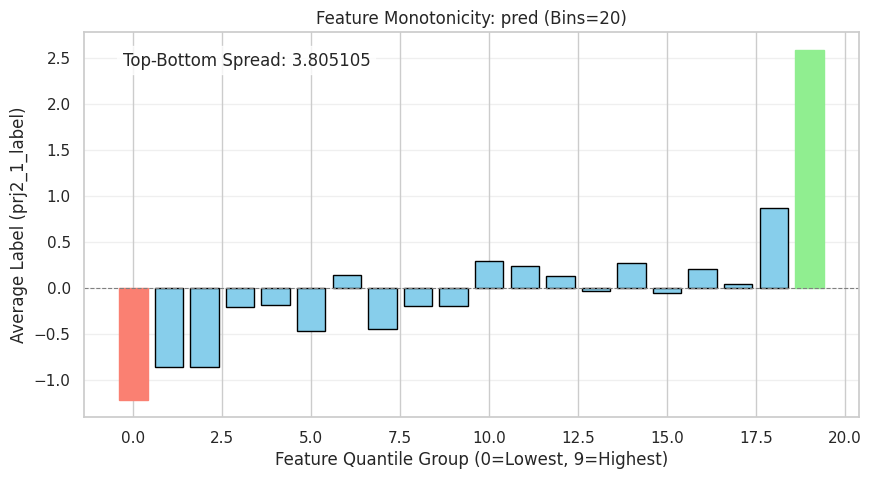

In [392]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_feature_spread(df, feature_col, label_col, quantile=0.1, group_by_day=True, day_col='trade_day'):
    """
    计算特征 Top N% 和 Bottom N% 的 Label 均值差 (Long-Short Spread)
    
    Args:
        df: DataFrame
        feature_col: 特征列名
        label_col: 标签列名 (预测目标，如收益率)
        quantile: 前后百分比 (默认 0.1，即 10%)
        group_by_day: 是否按天分组计算 (强烈建议 True，防止不同日期的市场Beta干扰)
        day_col: 日期列名 (当 group_by_day=True 时必填)
        
    Returns:
        dict: 包含 spread, top_mean, bottom_mean 的字典
    """
    
    # 内部函数：处理单个 Group 或整个 DataFrame
    def _calc_single_group(sub_df):
        # 去除空值
        sub_df = sub_df.dropna(subset=[feature_col, label_col])
        if len(sub_df) == 0:
            return pd.Series({'top': np.nan, 'bottom': np.nan, 'spread': np.nan})
            
        # 确定切分点
        n = len(sub_df)
        k = int(n * quantile)
        
        if k == 0: # 数据太少不足以切分
            return pd.Series({'top': np.nan, 'bottom': np.nan, 'spread': np.nan})
        
        # 按特征排序
        # ascending=True: 头部是小值(Bottom), 尾部是大值(Top)
        sorted_df = sub_df.sort_values(by=feature_col, ascending=True)
        
        # 提取 Bottom (特征最小的 10%)
        bottom_part = sorted_df.iloc[:k]
        # 提取 Top (特征最大的 10%)
        top_part = sorted_df.iloc[-k:]
        
        # 计算 Label 均值
        bottom_mean = bottom_part[label_col].mean()
        top_mean = top_part[label_col].mean()
        
        return pd.Series({
            'top_mean': top_mean,
            'bottom_mean': bottom_mean,
            'spread': top_mean - bottom_mean
        })

    # --- 模式 A: 按天分组计算 (推荐) ---
    if group_by_day:
        if day_col not in df.columns:
            raise ValueError(f"按天分组模式下，DataFrame 必须包含 '{day_col}' 列")
            
        print(f"正在按 {day_col} 分组计算每日 Spread...")
        daily_stats = df.groupby(day_col).apply(_calc_single_group)
        
        # 计算所有天数的平均值
        final_stats = daily_stats.mean()
        
        # 也可以返回 daily_stats 以便画出 spread 的时序图
        return {
            'spread': final_stats['spread'],
            'top_mean': final_stats['top_mean'], 
            'bottom_mean': final_stats['bottom_mean'],
            'daily_data': daily_stats # 附带每日详情
        }

    # --- 模式 B: 全局混合计算 (仅用于快速查看分布) ---
    else:
        result = _calc_single_group(df)
        return result.to_dict()

# ==========================================
# 2. 辅助：可视化函数 (分组柱状图)
# ==========================================
def plot_quantile_performance(df, feature_col, label_col, n_bins=20):
    """
    画出特征分层后的单调性柱状图
    """
    df_clean = df.dropna(subset=[feature_col, label_col]).copy()
    
    # 将特征分为 N 组
    # labeling=False 返回 0, 1, ... 9
    df_clean['group'] = pd.qcut(df_clean[feature_col], n_bins, labels=False, duplicates='drop')
    
    # 计算每组的 Label 均值
    group_means = df_clean.groupby('group')[label_col].mean() - df_clean[label_col].mean()
    
    plt.figure(figsize=(10, 5))
    bars = plt.bar(group_means.index, group_means.values, color='skyblue', edgecolor='black')
    
    # 标记最高和最低组
    bars[0].set_color('salmon') # Bottom 10%
    bars[-1].set_color('lightgreen') # Top 10%
    
    plt.title(f"Feature Monotonicity: {feature_col} (Bins={n_bins})")
    plt.xlabel("Feature Quantile Group (0=Lowest, 9=Highest)")
    plt.ylabel(f"Average Label ({label_col})")
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.grid(axis='y', alpha=0.3)
    
    # 计算简单的 spread
    spread = group_means.iloc[-1] - group_means.iloc[0]
    plt.text(0.05, 0.95, f"Top-Bottom Spread: {spread:.6f}", 
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
    
    plt.show()

# ==========================================
# 使用示例
# ==========================================
if __name__ == "__main__":
    
    plot_quantile_performance(valid_new, 'pred', 'prj2_1_label', n_bins=20)

In [ ]:
data_all = pd.concat([train_new,valid_new])


In [ ]:
data_all['rp_momentum_120'].describe()

count    8.313900e+04
mean    -6.299968e+02
std      2.531210e+05
min     -2.531388e+07
25%     -9.896666e+02
50%      1.082826e+00
75%      1.035259e+03
max      2.122914e+07
Name: rp_momentum_120, dtype: float64

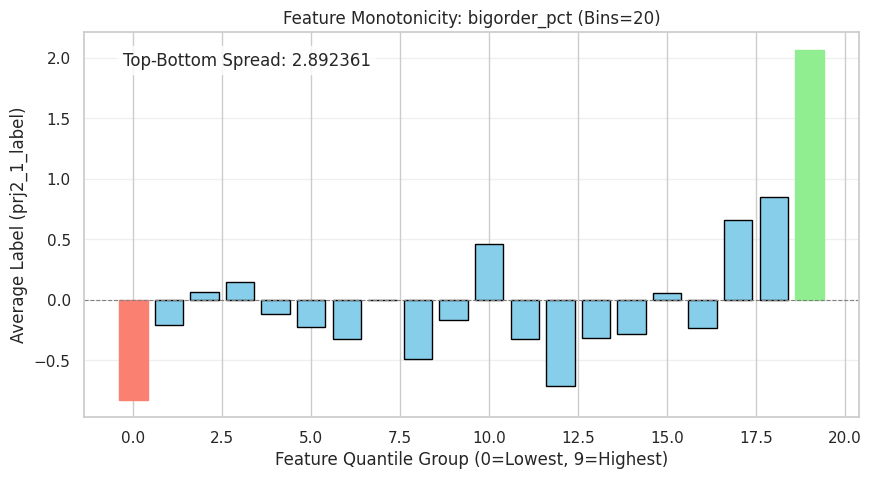

In [ ]:
plot_quantile_performance(valid_new, 'bigorder_pct', 'prj2_1_label', n_bins=20)

In [ ]:
valid_df['prj2_1_label'].quantile(0.95)

np.float64(10.332947050570137)

In [ ]:
'gate_session_decay','gate_open_impulse'

In [ ]:
train_origin = pd.read_pickle("/home/zyyuan/project2/processed_data/traindata_origin.pkl")
valid_origin = pd.read_pickle("/home/zyyuan/project2/processed_data/validdata_origin.pkl")

In [ ]:
pd.read_pickle("/home/zyyuan/project2/final_dataset/train_context.pkl")

type source  trade_day  action_day    inst                 hms   ms  \
0        D      M 2025-04-25  2025-04-24  ag2506 2025-04-24 20:59:00  500   
1        D      M 2025-04-25  2025-04-24  ag2506 2025-04-24 21:00:30    0   
2        D      M 2025-04-25  2025-04-24  ag2506 2025-04-24 21:01:00    0   
3        D      M 2025-04-25  2025-04-24  ag2506 2025-04-24 21:01:30    0   
4        D      M 2025-04-25  2025-04-24  ag2506 2025-04-24 21:02:00    0   
...    ...    ...        ...         ...     ...                 ...  ...   
75716    D      M 2025-08-12  2025-08-11  ag2510 2025-08-11 23:56:57  500   
75717    D      M 2025-08-12  2025-08-11  ag2510 2025-08-11 23:57:36  500   
75718    D      M 2025-08-12  2025-08-11  ag2510 2025-08-11 23:58:15  500   
75719    D      M 2025-08-12  2025-08-11  ag2510 2025-08-11 23:58:50  500   
75720    D      M 2025-08-12  2025-08-11  ag2510 2025-08-11 23:59:27  500   

       last  volume   bp1  ...  struct_rev_30  volume_threshold  trend_10  \
0      8298     409  8297  ...            NaN               NaN       NaN   
1      8293    3916  8292  ...            NaN               NaN       NaN   
2      8292    5049  8291  ...            NaN               NaN       NaN   
3      8293    6260  8292  ...            NaN               NaN       NaN   
4      8294    7303  8292  ...            NaN               NaN       NaN   
...     ...     ...   ...  ...            ...               ...       ...   
75716  9154  145618  9153  ...       0.154289         -0.741614  0.005428   
75717  9154  145646  9153  ...       0.164673         -0.742648  0.005428   
75718  9153  145683  9153  ...       0.272327         -0.746396  0.005428   
75719  9154  145748  9153  ...       0.917294         -0.746396  0.005428   
75720  9156  145862  9155  ...      -0.163277         -0.746396  0.005428   

       trend_30       atr      ma20  upper_bb  lower_bb  turnover_5min  \
0           NaN       NaN       NaN       NaN       NaN            NaN   
1           NaN       NaN       NaN       NaN       NaN            NaN   
2           NaN       NaN       NaN       NaN       NaN            NaN   
3           NaN       NaN       NaN       NaN       NaN            NaN   
4           NaN       NaN       NaN       NaN       NaN       3.081777   
...         ...       ...       ...       ...       ...            ...   
75716  0.194258 -0.885404  0.993973 -0.554538  0.733535      -0.394880   
75717  0.209740 -0.918608  0.993973 -0.554538  0.733535      -0.402822   
75718  0.227930 -0.951813  0.993849 -0.561860  0.728860      -0.371053   
75719  0.224881 -0.985018  0.993849 -0.561860  0.728860      -0.291621   
75720  0.018619 -0.985214  0.993973 -0.774079  0.465953      -0.283677   

       turnover_10min  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
...               ...  
75716       -0.608303  
75717       -0.608303  
75718       -0.589092  
75719       -0.525046  
75720       -0.518640  

[75721 rows x 323 columns]

In [ ]:
train_final['timestamp']

0       2025-04-24 21:01:19.500
1       2025-04-24 21:01:49.500
2       2025-04-24 21:02:19.500
3       2025-04-24 21:02:49.500
4       2025-04-24 21:03:19.500
                  ...          
68222   2025-08-07 14:42:44.500
68223   2025-08-07 14:43:14.500
68224   2025-08-07 14:43:44.500
68225   2025-08-07 14:44:14.500
68226   2025-08-07 14:44:44.500
Name: timestamp, Length: 68227, dtype: datetime64[ns]

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numba import jit
from sklearn.preprocessing import StandardScaler

# ================= 配置 =================
CONFIG = {
    # 假设你已经加载了 train_df 和 valid_df
    # 这里填入你需要计算衍生特征的列名
    'target_features': ['f_35_7', 'f_31_28', 'f_4_117', 'f_84_37', 'f_84_38', 'f_75_241', 'f_35_6', 'f_77_7', 'f_33_28', 'f_85_38', 'f_85_39', 'f_87_45', 'f_7_30', 'f_73_83', 'f_84_39', 'f_93_234', 'f_43_7', 'f_75_239', 'f_45_7', 'f_5_26', 'f_42_7', 'f_75_242', 'f_92_326', 'f_85_40', 'f_6_105', 'f_37_7', 'f_18_41', 'f_43_6', 'f_5_28', 'f_17_36', 'f_36_7', 'f_44_7', 'f_92_371', 'f_93_226', 'f_52_40', 'f_79_35', 'f_5_27', 'f_93_224', 'f_7_32', 'f_6_97', 'f_47_7', 'f_4_120', 'f_20_47', 'f_4_126', 'f_18_36', 'f_43_5', 'f_92_345', 'f_14_37', 'f_15_48', 'f_6_106', 'f_73_78', 'f_34_7', 'f_89_24', 'f_74_369', 'f_64_159', 'f_32_28', 'f_7_29', 'f_36_6', 'f_79_33', 'f_34_6', 'f_91_43', 'f_20_42', 'f_47_6', 'f_18_38', 'f_89_19', 'f_20_44', 'f_55_36', 'f_74_395', 'f_19_37', 'f_64_157', 'f_8_32', 'f_74_378', 'f_80_20', 'f_32_24', 'f_32_20', 'f_17_29', 'f_62_19', 'f_31_24', 'f_19_38', 'f_34_5', 'f_55_37', 'f_90_45', 'f_8_29', 'f_80_19', 'f_17_38', 'f_49_22', 'f_91_38', 'f_55_40', 'f_80_16', 'f_49_10', 'f_90_47', 'f_76_7', 'f_49_28', 'f_72_61', 'f_40_7', 'f_15_47', 'f_73_84', 'f_52_22', 'f_72_76', 'f_63_158', 'f_38_7', 'f_52_18', 'f_56_42', 'f_33_24', 'f_72_82', 'f_53_34', 'f_35_4', 'f_87_46', 'f_8_31', 'f_16_46', 'f_16_34', 'f_33_25', 'f_71_66', 'f_16_43', 'f_91_37', 'f_71_84', 'f_50_40', 'f_90_37', 'f_71_70', 'f_42_5', 'f_79_31', 'f_13_42', 'f_78_7', 'f_63_157', 'f_14_40', 'f_87_43', 'f_19_41', 'f_86_46', 'f_86_40', 'f_67_42', 'f_64_133', 'f_53_22', 'f_46_7', 'f_13_39', 'f_63_153', 'f_42_6', 'f_53_18', 'f_67_32', 'f_3_41', 'f_56_31', 'f_61_16', 'f_15_46', 'f_22_7', 'f_86_43', 'f_62_4', 'f_3_38', 'f_31_22', 'f_69_13', 'f_48_19', 'f_38_4', 'f_69_19', 'f_51_35', 'f_13_35', 'f_14_35', 'f_37_6', 'f_37_4', 'f_11_7', 'f_54_6', 'f_54_3', 'f_38_5', 'f_88_16'],
    'window_size': 30,       # 滚动窗口
    'min_periods': 10,       # 最小观测窗口
}

# ================= 1. Numba 函数 (保持不变) =================
@jit(nopython=True, nogil=True)
def _calculate_rolling_slope_numba(arr, window):
    n = len(arr)
    out = np.full(n, np.nan, dtype=np.float32)
    if n < window:
        return out

    sum_x = window * (window - 1) / 2.0
    sum_x_sq = window * (window - 1) * (2 * window - 1) / 6.0
    divisor = window * sum_x_sq - sum_x * sum_x
    
    for i in range(window - 1, n):
        sum_y = 0.0
        sum_xy = 0.0
        valid = True
        for j in range(window):
            val = arr[i - window + 1 + j]
            if np.isnan(val):
                valid = False
                break
            sum_y += val
            sum_xy += j * val
            
        if valid:
            out[i] = (window * sum_xy - sum_x * sum_y) / divisor
            
    return out

# ================= 2. 特征生成逻辑 (保持不变) =================
def generate_rolling_features(df, target_cols, window=30, min_periods=10):
    if not target_cols:
        return df, []
    
    new_features = {}
    epsilon = 1e-9 
    
    for col in target_cols:
        if col not in df.columns:
            continue
            
        series = df[col]
        values = series.values.astype(np.float32)
        
        # 复用 rolling 对象
        roll = series.rolling(window, min_periods=min_periods)
        
        roll_mean = roll.mean()
        roll_std = roll.std()
        
        # 1. Z-Score
        z_score = (series - roll_mean) / (roll_std + epsilon)
        new_features[f'{col}_zscore_{window}'] = z_score.clip(-5, 5)
        
        # 2. 相对振幅
        roll_max = roll.max()
        roll_min = roll.min()
        rel_amp = (roll_max - roll_min) / (roll_mean.abs() + epsilon)
        new_features[f'{col}_rel_amp_{window}'] = rel_amp
        
        # 3. 排名
        new_features[f'{col}_rank_{window}'] = roll.rank(pct=True)
        
        # 4. 相对斜率
        raw_slope = _calculate_rolling_slope_numba(values, window)
        rel_slope = raw_slope / (roll_mean.abs() + epsilon)
        
        # 处理 Slope 冷启动 (填充 min_periods 到 window 之间的空隙)
        slope_series = pd.Series(rel_slope, index=df.index)
        mask_valid_rolling = df.index >= (min_periods - 1)
        slope_series.iloc[mask_valid_rolling] = slope_series.iloc[mask_valid_rolling].fillna(0)
        
        new_features[f'{col}_rel_slope_{window}'] = np.clip(slope_series.values, -10, 10)

    new_df_cols = pd.DataFrame(new_features, index=df.index).astype(np.float32)
    df = pd.concat([df, new_df_cols], axis=1)
    
    return df, list(new_features.keys())

# ================= 3. 逐日计算封装函数 (修改版) =================
def process_dataframe_daily(df, target_cols, window=30, min_periods=10, desc="Processing"):
    """
    按 trade_day 分组 -> 重置索引 -> 计算特征 -> 去除冷启动行 -> 拼接
    """
    if df is None or df.empty:
        return df, []
    
    # 检查 trade_day 列是否存在
    if 'trade_day' not in df.columns:
        raise ValueError("DataFrame 中缺少 'trade_day' 列，无法按交易日分组。")
    
    processed_chunks = []
    new_feat_names = []
    
    # [修改点] 直接按 trade_day 分组
    # 注意：前提是数据已经按照 (trade_day, timestamp) 排序过，否则 reset_index 后顺序会乱
    groups = df.groupby('trade_day')
    
    for trade_day, daily_df in tqdm(groups, desc=desc):
        # [关键步骤]：必须重置索引！确保 rolling 窗口逻辑正确
        daily_df = daily_df.reset_index(drop=True)
        
        # 计算特征
        daily_df, current_new_feats = generate_rolling_features(
            daily_df, 
            target_cols, 
            window=window, 
            min_periods=min_periods
        )
        
        if not new_feat_names and current_new_feats:
            new_feat_names = current_new_feats
            
        # 去除每天开盘前的冷启动数据 (前 min_periods-1 行)
        daily_df.dropna(inplace=True)
        
        if not daily_df.empty:
            processed_chunks.append(daily_df)
            
    # 重新拼接
    print(f"拼接 {len(processed_chunks)} 个交易日的数据...")
    if not processed_chunks:
        return pd.DataFrame(), []
        
    final_df = pd.concat(processed_chunks, ignore_index=True)
    
    return final_df, new_feat_names

# ================= 4. 主执行逻辑 =================
def main_process(train_df, valid_df, target_features):
    # 确保数据已按时间排序 (防御性编程)
    print("正在检查数据排序...")
    if 'trade_day' in train_df.columns and 'timestamp' in train_df.columns:
        train_df = train_df.sort_values(['trade_day', 'timestamp'])
    
    if 'trade_day' in valid_df.columns and 'timestamp' in valid_df.columns:
        valid_df = valid_df.sort_values(['trade_day', 'timestamp'])

    print(">>> 开始处理训练集 (Train)...")
    train_df_aug, new_feats = process_dataframe_daily(
        train_df, 
        target_features, 
        window=CONFIG['window_size'], 
        min_periods=CONFIG['min_periods'],
        desc="Train Daily Calc"
    )
    
    print(">>> 开始处理验证集 (Valid)...")
    valid_df_aug, _ = process_dataframe_daily(
        valid_df, 
        target_features, 
        window=CONFIG['window_size'], 
        min_periods=CONFIG['min_periods'],
        desc="Valid Daily Calc"
    )
    
    # 5. 对新特征进行标准化
    if new_feats:
        print(f"正在对 {len(new_feats)} 个新特征进行标准化...")
        scaler = StandardScaler()
        
        # Fit on Train
        scaler.fit(train_df_aug[new_feats].values)
        
        # Transform Train & Valid
        train_df_aug[new_feats] = scaler.transform(train_df_aug[new_feats].values).astype(np.float32)
        if not valid_df_aug.empty:
            valid_df_aug[new_feats] = scaler.transform(valid_df_aug[new_feats].values).astype(np.float32)
            
    train_df_aug = train_df_aug[['trade_day','timestamp']+new_feats]
    valid_df_aug = valid_df_aug[['trade_day','timestamp']+new_feats]
    return train_df_aug, valid_df_aug

train_final, valid_final = main_process(train_origin, valid_origin, CONFIG['target_features'])
        

正在检查数据排序...
>>> 开始处理训练集 (Train)...


Train Daily Calc:   0%|          | 0/70 [00:00<?, ?it/s]Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x76b81c9a0540>
Traceback (most recent call last):
  File "/usr/lib/python3.12/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 
Train Daily Calc: 100%|██████████| 70/70 [00:24<00:00,  2.87it/s]


拼接 70 个交易日的数据...
>>> 开始处理验证集 (Valid)...


Valid Daily Calc: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


拼接 16 个交易日的数据...
正在对 644 个新特征进行标准化...


In [ ]:
train_final = pd.merge(left = train_df,right = train_final,on = ['timestamp'],how = 'left')
valid_final = pd.merge(left = valid_df,right = valid_final,on = ['timestamp'],how = 'left')

In [ ]:
train_final.shape

(71131, 4899)

In [ ]:
total_df = pd.concat([train_df,valid_df])
factortest = total_df[new_factors].corrwith(total_df['prj2_1_label']).abs().sort_values()
use_factors = factortest[factortest>=0.05].index.tolist()
len(use_factors)

21

In [ ]:
test_factors = [x for x in train_df.columns if 'amp' in x]

In [ ]:
rank_factors = ['f_31_28_rank_30',
 'f_33_28_rank_30',
 'f_7_30_rank_30',
 'f_5_26_rank_30',
 'f_92_371_rank_30',
 'f_92_345_rank_30',
 'f_13_39_rank_30']

In [ ]:

factor_test = pd.DataFrame(index = test_factors)
factor_test['train_IC'] = train_df[test_factors].corrwith(train_df['prj2_1_label'])
factor_test['valid_IC'] = valid_df[test_factors].corrwith(valid_df['prj2_1_label'])
factor_test = factor_test[(factor_test['train_IC']*factor_test['valid_IC']>0)&(factor_test['valid_IC'].abs()>=0.01)]
factor_test['absIC'] = factor_test['train_IC'].abs()
use_factors = factor_test[factor_test['absIC']>=0.01].index.tolist()
use_factors

['f_4_120_amp', 'f_93_234_amp', 'f_93_224_amp', 'f_4_119_amp']

In [ ]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.fillna(0, inplace=True)
valid_df.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_df.fillna(0, inplace=True)

In [ ]:
total_df[use_factors].describe()

f_50_12_amp_30  f_86_37_amp_30  f_31_27_mean_30  f_54_42_mean_30  \
count    83252.000000    83252.000000     83252.000000     83252.000000   
mean         0.002868       -0.053321        -0.050843        -0.011219   
std          0.966770        0.962960         0.982396         0.989590   
min         -1.503774       -1.292518        -1.673834        -3.602395   
25%         -0.705498       -0.641382        -0.719301        -0.712011   
50%         -0.195759       -0.306172        -0.261661        -0.004048   
75%          0.453330        0.227093         0.351633         0.687937   
max          5.461703       13.257758         8.397949         3.244911   

       f_73_64_mean_30  f_16_46_amp_30  f_56_40_mean_30  f_62_21_mean_30  \
count     83252.000000    83252.000000     83252.000000     83252.000000   
mean         -0.012729        0.061662         0.001063        -0.001029   
std           0.973623        1.017659         1.017077         0.989963   
min         -10.782436       -1.660924        -8.945980        -4.000566   
25%          -0.429031       -0.621956        -0.472236        -0.604198   
50%          -0.024529       -0.148803         0.021256         0.026875   
75%           0.371448        0.480316         0.519841         0.593642   
max          19.603426       10.496032         5.519116         4.401977   

       f_89_20_amp_30  f_43_7_mean_30  ...  f_2_35_mean_30  f_1_34_mean_30  \
count    83252.000000    83252.000000  ...    83252.000000    83252.000000   
mean         0.037156        0.024426  ...       -0.001503        0.000073   
std          1.006050        0.946058  ...        1.016641        0.967765   
min         -2.198927      -13.454132  ...       -5.126557       -6.612032   
25%         -0.660033       -0.227315  ...       -0.599151       -0.398284   
50%         -0.132027        0.001199  ...        0.011180        0.012321   
75%          0.519130        0.301502  ...        0.595023        0.440355   
max          9.680320       12.447087  ...        6.306250        8.799603   

       f_2_34_mean_30  f_1_7_mean_30  f_67_25_mean_30  f_67_40_mean_30  \
count    83252.000000   83252.000000     83252.000000     83252.000000   
mean        -0.000064      -0.006273        -0.001264        -0.002187   
std          1.004190       0.977830         1.003870         0.998614   
min         -6.264513      -6.768425        -6.192779        -5.069895   
25%         -0.496565      -0.445592        -0.568096        -0.612215   
50%          0.022220       0.001612         0.007639         0.005047   
75%          0.515736       0.446897         0.575252         0.630472   
max          6.878043       7.059175         4.779991         4.078045   

       f_3_34_mean_30  f_47_7_mean_30  f_47_5_mean_30  f_47_6_mean_30  
count    83252.000000    83252.000000    83252.000000    83252.000000  
mean        -0.001916       -0.003102       -0.003257       -0.003479  
std          0.950910        0.946844        0.947702        0.945793  
min         -9.159836      -13.289485       -7.013489      -11.913521  
25%         -0.362034       -0.233363       -0.269662       -0.245334  
50%          0.000407       -0.054245       -0.051710       -0.052057  
75%          0.374300        0.168212        0.204976        0.172817  
max          8.419653       17.133183       16.828608       18.263582  

[8 rows x 51 columns]

In [ ]:
feature_cols = top_factors+new_factors
importance_gain = final_model.feature_importance(importance_type='gain') # 增益 (推荐)
importance_split = final_model.feature_importance(importance_type='split') # 分裂次数
    
feature_imp = pd.DataFrame({
        'feature': feature_cols,
        'gain': importance_gain,
        'split': importance_split
    })
feature_imp

feature          gain  split
0             f_31_28      0.000000      0
1             f_85_40  17597.599609      1
2              f_35_6      0.000000      0
3             f_85_41      0.000000      0
4             f_84_38      0.000000      0
..                ...           ...    ...
849   f_35_3_slope_30      0.000000      0
850   f_67_25_mean_30      0.000000      0
851    f_67_25_amp_30   3785.209961      1
852   f_67_25_rank_30      0.000000      0
853  f_67_25_slope_30      0.000000      0

[854 rows x 3 columns]

In [ ]:
daily_features = pd.read_parquet("/home/zyyuan/project2/feature_generate_all_np_ag_v5_intern_parquet/ag2508_20250513_features.parquet")
daily_features

In [ ]:
daily_features['prj2_1_label'].describe()

count    59734.000000
mean        -0.073051
std          6.914131
min        -23.297824
25%         -4.208228
50%          0.577321
75%          4.335841
max         20.002626
Name: prj2_1_label, dtype: float64

In [ ]:
context = pd.read_parquet("/home/zyyuan/project2/processed_marketdata_parquet/20250425_SHFE_ag2506_features.parquet")
factors = ontext.columns[69:]


Index(['timestamp', 'delta_volume', 'bigorder_volume', 'delta_turnover',
       'mid_price', 'trade_direction', 'buy_volume', 'sell_volume',
       'net_inflow', 'estimated_exec_price',
       ...
       'struct_rev_30', 'volume_threshold', 'trend_10', 'trend_30', 'atr',
       'ma20', 'upper_bb', 'lower_bb', 'turnover_5min', 'turnover_10min'],
      dtype='object', length=255)